In [1]:
pip install shap lightgbm xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
import shap

# Model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
import warnings
warnings.filterwarnings('ignore')



In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
print(f"train_df shape: {train_df.shape}")
print(f"test_df shape: {test_df.shape}")
print(f"test_df columns: {test_df.columns}")
print(f"train_df columns: {train_df.columns}")
print(f"train_df head: {train_df.head()}")
print(f"test_df head: {test_df.head()}")
print(f"train_df info: {train_df.info()}")
print(f"test_df info: {test_df.info()}")
print(f"train_df describe: {train_df.describe()}")
print(f"test_df describe: {test_df.describe()}")
print(f"train_df missing values: {train_df.isnull().sum()}")
print(f"test_df missing values: {test_df.isnull().sum()}")
print(f"train_df missing values: {train_df.isnull().sum()}")

train_df shape: (18524, 9)
test_df shape: (6175, 8)
test_df columns: Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency'],
      dtype='object')
train_df columns: Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')
train_df head:    id  Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0   0               0.0         No                      6.0            4.0   
1   1               1.0         No                      7.0            3.0   
2   2               6.0        Yes                      1.0            0.0   
3   3               3.0         No                      7.0            3.0   
4   4               1.0         No                      4.0            4.0   

  Drained_after_so

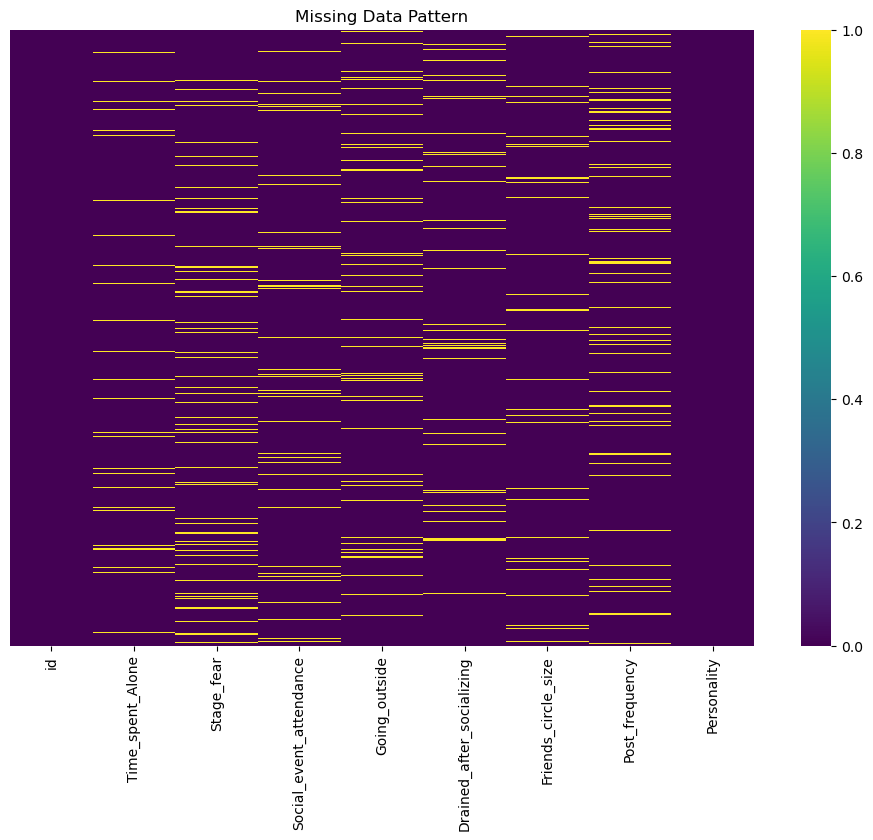

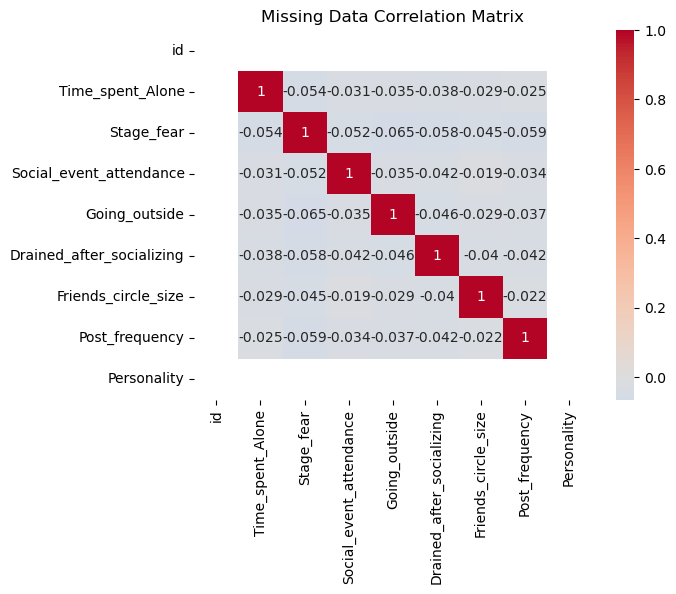

In [5]:
# Missing data heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Data Pattern')
plt.show()

# Missing data correlation
missing_corr = train_df.isnull().corr()
sns.heatmap(missing_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Missing Data Correlation Matrix')
plt.show()

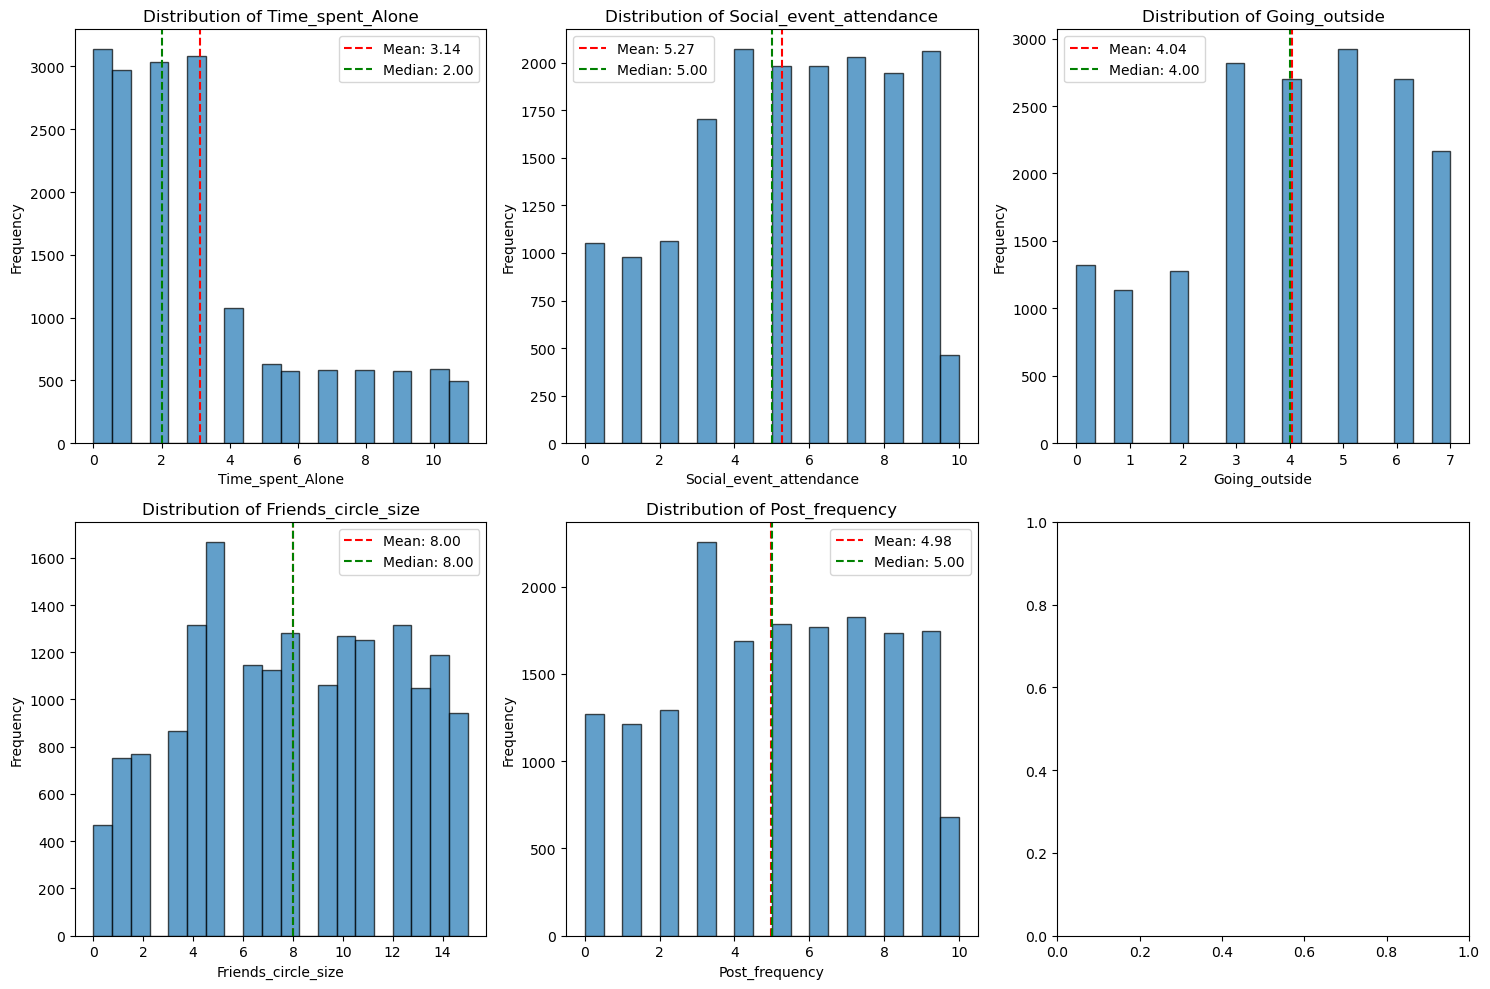

In [6]:
numerical_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 
                 'Friends_circle_size', 'Post_frequency']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    # Distribution plot
    axes[i].hist(train_df[col].dropna(), bins=20, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    
    # Add statistics
    mean_val = train_df[col].mean()
    median_val = train_df[col].median()
    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

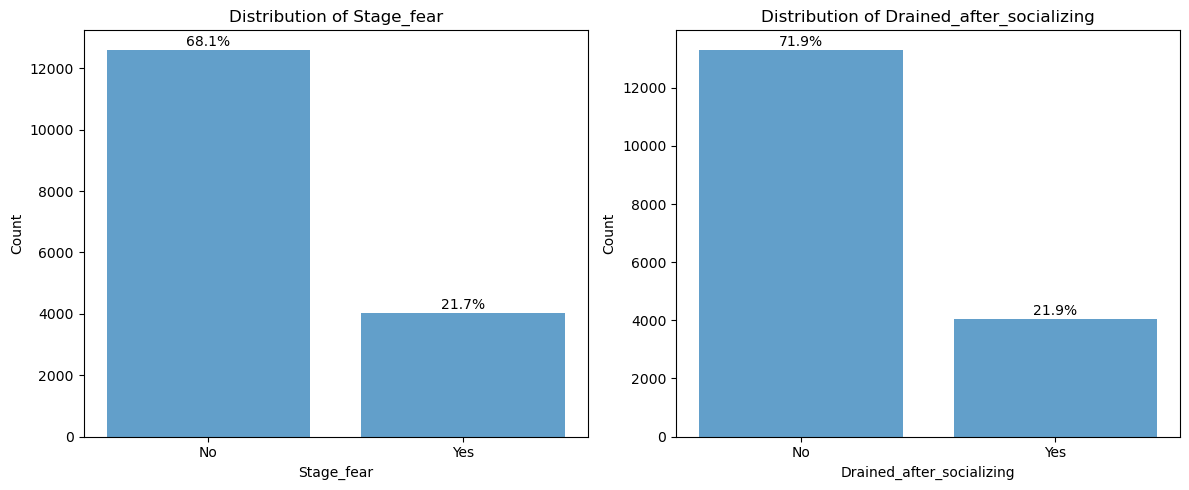

In [7]:
categorical_cols = ['Stage_fear', 'Drained_after_socializing']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, col in enumerate(categorical_cols):
    value_counts = train_df[col].value_counts()
    axes[i].bar(value_counts.index, value_counts.values, alpha=0.7)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    
    # Add percentages
    for j, v in enumerate(value_counts.values):
        axes[i].text(j, v + max(value_counts.values)*0.01, 
                    f'{v/len(train_df)*100:.1f}%', ha='center')

plt.tight_layout()
plt.show()

Class distribution:
Personality
Extrovert    13699
Introvert     4825
Name: count, dtype: int64
Class imbalance ratio: 2.84


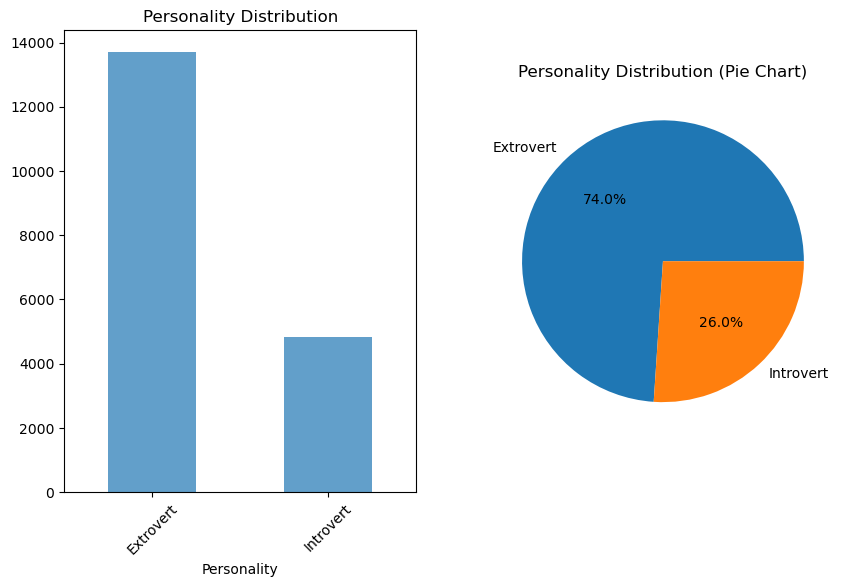

In [8]:
# Personality distribution
personality_dist = train_df['Personality'].value_counts()
print(f"Class distribution:\n{personality_dist}")
print(f"Class imbalance ratio: {personality_dist.max() / personality_dist.min():.2f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
personality_dist.plot(kind='bar', alpha=0.7)
plt.title('Personality Distribution')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.pie(personality_dist.to_numpy(), labels=personality_dist.index.tolist(), autopct='%1.1f%%')
plt.title('Personality Distribution (Pie Chart)')
plt.show()

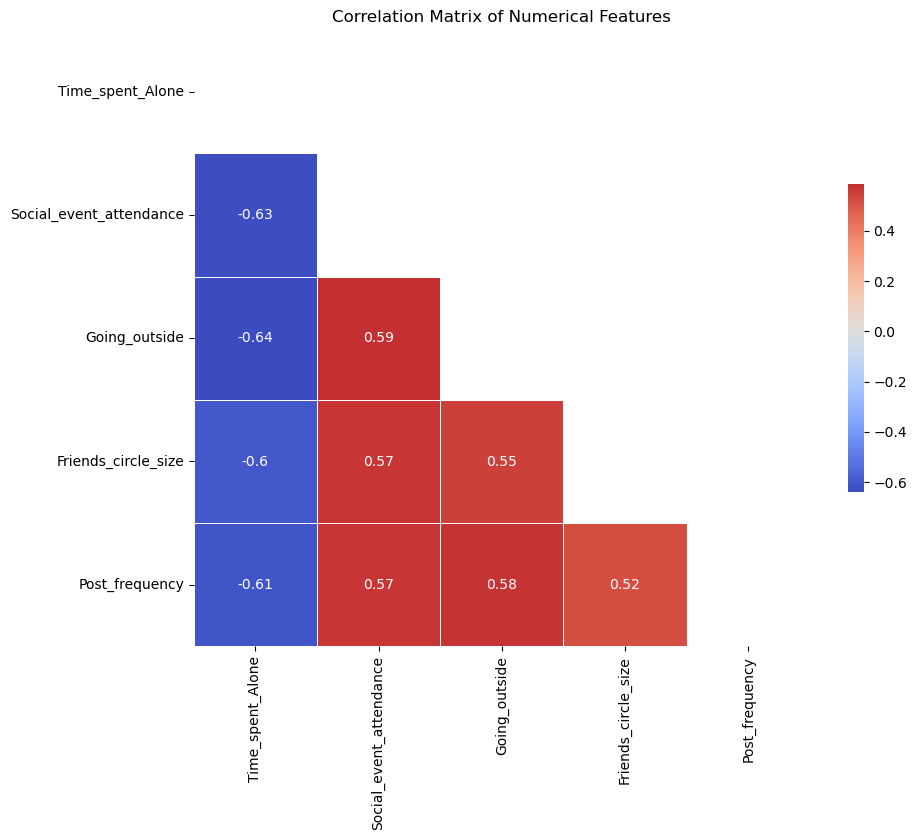

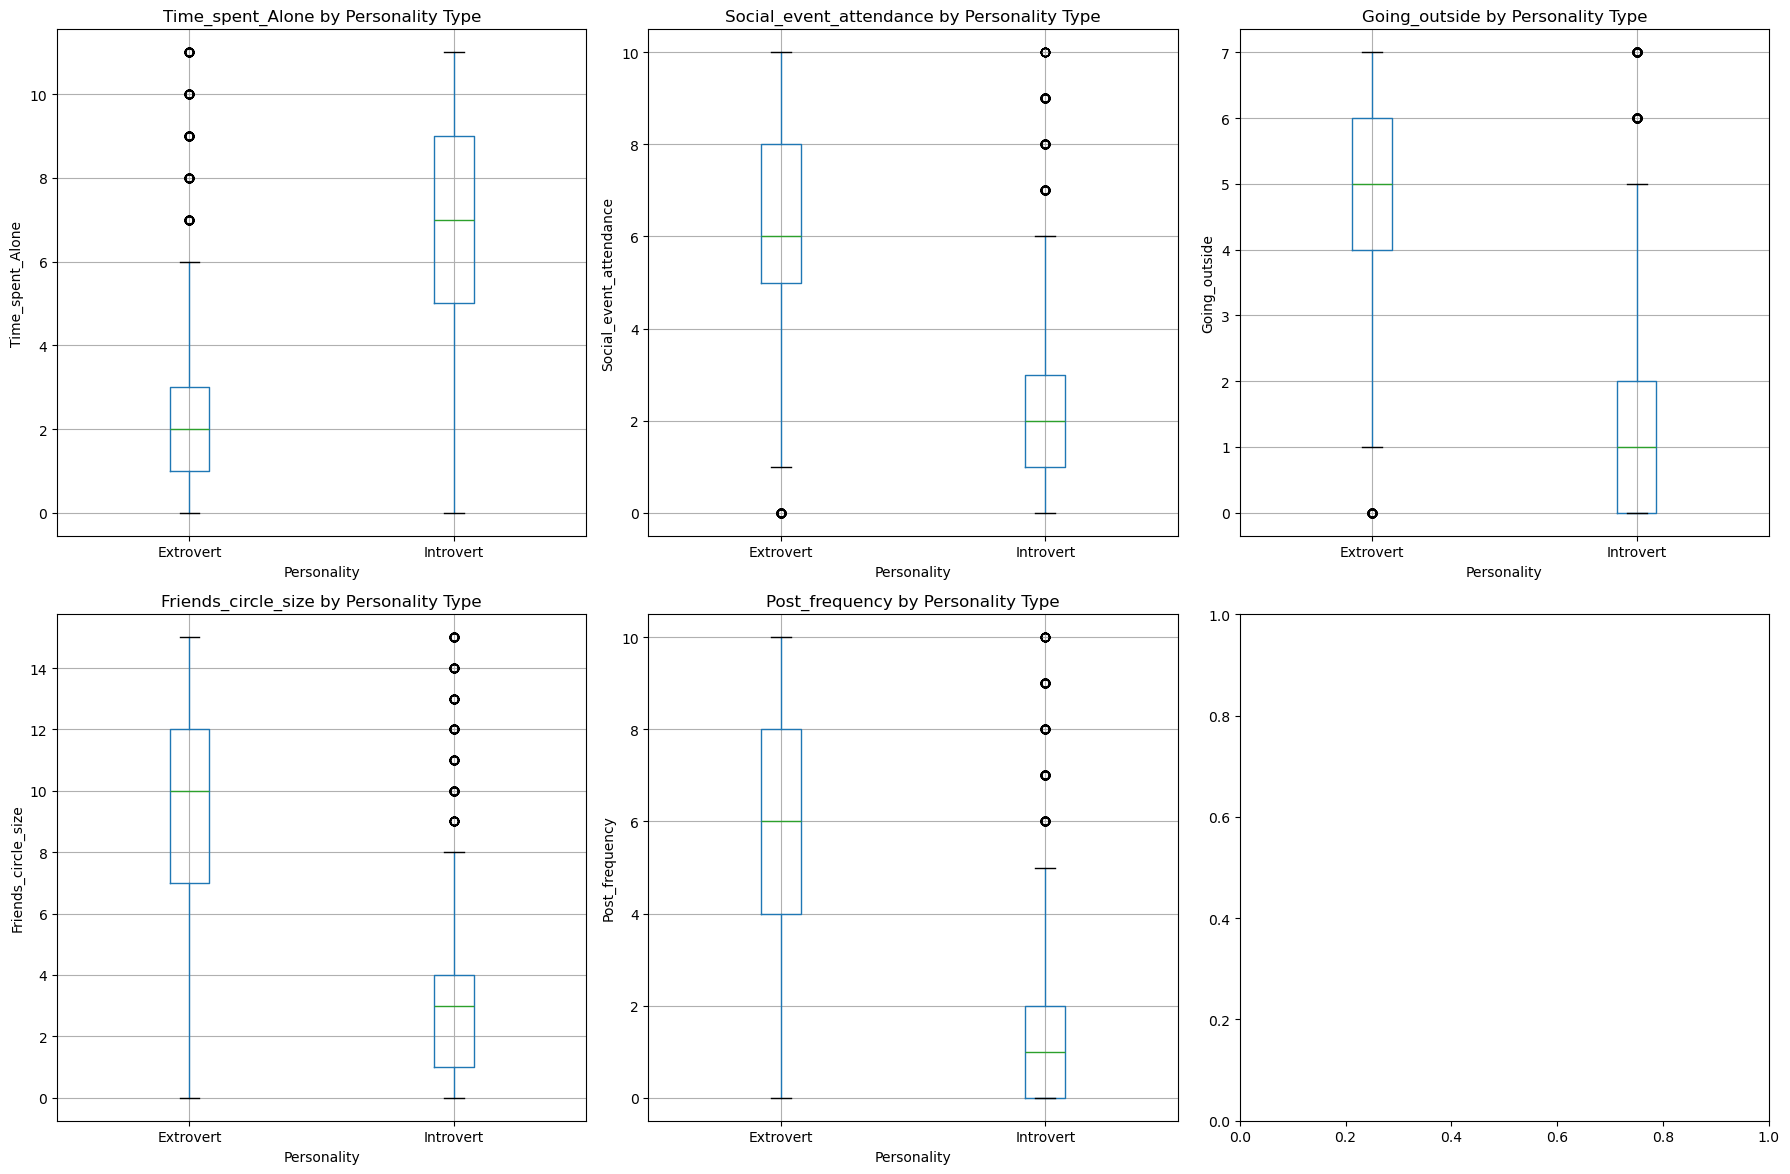

In [9]:
# Create a correlation matrix for numerical features
numerical_df = train_df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(numerical_df, dtype=bool))
sns.heatmap(numerical_df, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Feature relationships with target
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    train_df.boxplot(column=col, by='Personality', ax=axes[i])
    axes[i].set_title(f'{col} by Personality Type')
    axes[i].set_xlabel('Personality')
    axes[i].set_ylabel(col)

plt.suptitle('')  # Remove the automatic title
plt.tight_layout()
plt.show()

In [10]:
from scipy.stats import chi2_contingency, f_oneway, kruskal

# Chi-square tests for categorical variables
categorical_tests = {}
for col in ['Stage_fear', 'Drained_after_socializing']:
    if col in train_df.columns:
        contingency_table = pd.crosstab(train_df[col].fillna('Missing'), train_df['Personality'])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        categorical_tests[col] = {'chi2': chi2, 'p_value': p_value}
        print(f"Chi-square test for {col}: χ² = {chi2:.4f}, p-value = {p_value:.4f}")

# ANOVA tests for numerical variables
numerical_tests = {}
for col in numerical_cols:
    if col in train_df.columns:
        groups = [train_df[train_df['Personality'] == personality][col].dropna() 
                 for personality in train_df['Personality'].unique()]
        f_stat, p_value = f_oneway(*groups)
        numerical_tests[col] = {'f_stat': f_stat, 'p_value': p_value}
        print(f"ANOVA test for {col}: F = {f_stat:.4f}, p-value = {p_value:.4f}")

Chi-square test for Stage_fear: χ² = 13530.7256, p-value = 0.0000
Chi-square test for Drained_after_socializing: χ² = 14354.2184, p-value = 0.0000
ANOVA test for Time_spent_Alone: F = 26358.6601, p-value = 0.0000
ANOVA test for Social_event_attendance: F = 16933.3324, p-value = 0.0000
ANOVA test for Going_outside: F = 17227.0997, p-value = 0.0000
ANOVA test for Friends_circle_size: F = 13281.9167, p-value = 0.0000
ANOVA test for Post_frequency: F = 14711.0705, p-value = 0.0000


In [11]:
# Outlier detection using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, len(outliers)

# Detect outliers for each numerical column
outlier_summary = {}
for col in numerical_cols:
    if col in train_df.columns:
        outliers, count = detect_outliers_iqr(train_df, col)
        outlier_summary[col] = count
        print(f"Outliers in {col}: {count} ({count/len(train_df)*100:.2f}%)")

# Multivariate outlier detection using Isolation Forest
from sklearn.ensemble import IsolationForest

# Prepare data for isolation forest
numeric_data = train_df[numerical_cols].fillna(train_df[numerical_cols].median())
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_labels = iso_forest.fit_predict(numeric_data)
n_outliers = sum(outlier_labels == -1)
print(f"Multivariate outliers detected: {n_outliers} ({n_outliers/len(train_df)*100:.2f}%)")

Outliers in Time_spent_Alone: 1653 (8.92%)
Outliers in Social_event_attendance: 0 (0.00%)
Outliers in Going_outside: 0 (0.00%)
Outliers in Friends_circle_size: 0 (0.00%)
Outliers in Post_frequency: 0 (0.00%)
Multivariate outliers detected: 1853 (10.00%)


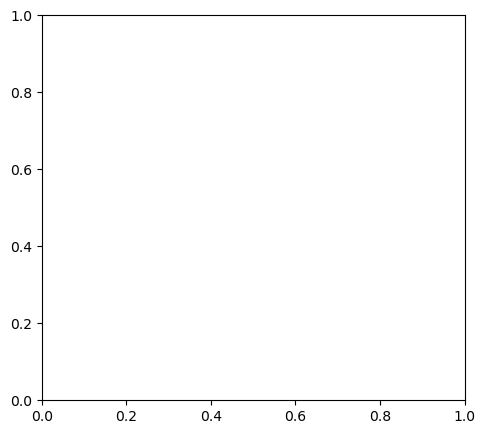

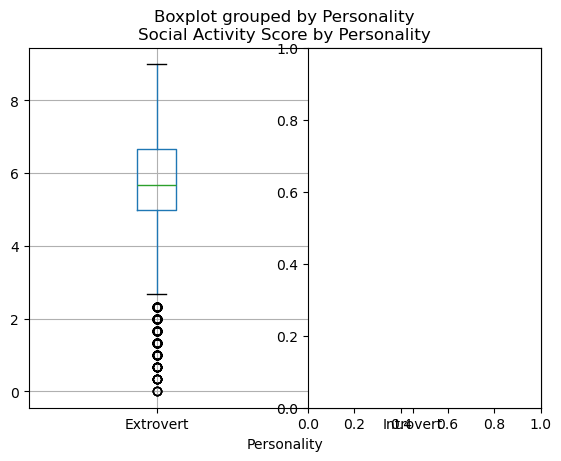

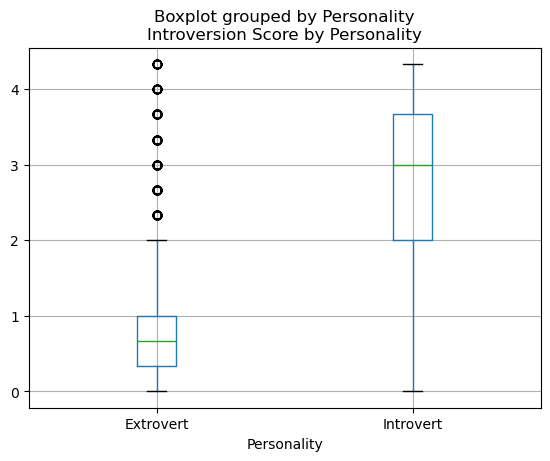

In [12]:
# Create interaction features for analysis
df_analysis = train_df.copy()

# Social activity score
df_analysis['Social_Activity_Score'] = (
    df_analysis['Social_event_attendance'].fillna(df_analysis['Social_event_attendance'].median()) +
    df_analysis['Going_outside'].fillna(df_analysis['Going_outside'].median()) +
    df_analysis['Post_frequency'].fillna(df_analysis['Post_frequency'].median())
) / 3

# Introversion indicators
df_analysis['Introversion_Score'] = (
    df_analysis['Time_spent_Alone'].fillna(df_analysis['Time_spent_Alone'].median()) +
    (df_analysis['Stage_fear'] == 'Yes').astype(int) +
    (df_analysis['Drained_after_socializing'] == 'Yes').astype(int)
) / 3

# Analyze these engineered features
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_analysis.boxplot(column='Social_Activity_Score', by='Personality')
plt.title('Social Activity Score by Personality')

plt.subplot(1, 2, 2)
df_analysis.boxplot(column='Introversion_Score', by='Personality')
plt.title('Introversion Score by Personality')
plt.show()

In [13]:
def run_data_validation_tests(df):
    tests = {}
    
    # Test 1: Data completeness
    completeness = (1 - df.isnull().sum() / len(df)) * 100
    tests['completeness'] = completeness
    
    # Test 2: Value range validation
    range_tests = {}
    for col in numerical_cols:
        if col in df.columns:
            valid_range = (df[col] >= 0) & (df[col] <= 10)  # Assuming 0-10 scale
            range_tests[col] = valid_range.sum() / valid_range.count() * 100
    tests['range_validation'] = range_tests
    
    # Test 3: Categorical value validation
    cat_tests = {}
    expected_values = {
        'Stage_fear': ['Yes', 'No'],
        'Drained_after_socializing': ['Yes', 'No'],
        'Personality': ['Introvert', 'Extrovert']
    }
    for col, expected in expected_values.items():
        if col in df.columns:
            valid_values = df[col].isin(expected + [np.nan])
            cat_tests[col] = valid_values.sum() / len(df) * 100
    tests['categorical_validation'] = cat_tests
    
    return tests

validation_results = run_data_validation_tests(train_df)
print("Data Validation Results:")
for test_name, results in validation_results.items():
    print(f"\n{test_name}:")
    if isinstance(results, dict):
        for key, value in results.items():
            print(f"  {key}: {value:.2f}%")
    else:
        print(f"  {results}")

Data Validation Results:

completeness:
  id                           100.000000
Time_spent_Alone              93.575902
Stage_fear                    89.780825
Social_event_attendance       93.629886
Going_outside                 92.085943
Drained_after_socializing     93.797236
Friends_circle_size           94.310084
Post_frequency                93.176420
Personality                  100.000000
dtype: float64

range_validation:
  Time_spent_Alone: 90.92%
  Social_event_attendance: 93.63%
  Going_outside: 92.09%
  Friends_circle_size: 63.27%
  Post_frequency: 93.18%

categorical_validation:
  Stage_fear: 100.00%
  Drained_after_socializing: 100.00%
  Personality: 100.00%


In [14]:
from scipy.stats import normaltest, levene

def run_statistical_tests(df):
    results = {}
    
    # Normality tests
    normality_results = {}
    for col in numerical_cols:
        if col in df.columns:
            data = df[col].dropna()
            if len(data) > 8:  # Minimum sample size for normality test
                stat, p_value = normaltest(data)
                normality_results[col] = {'statistic': stat, 'p_value': p_value, 
                                        'is_normal': p_value > 0.05}
    results['normality'] = normality_results
    
    # Homogeneity of variance tests
    variance_results = {}
    for col in numerical_cols:
        if col in df.columns:
            groups = [df[df['Personality'] == p][col].dropna() 
                     for p in df['Personality'].unique()]
            groups = [g for g in groups if len(g) > 1]  # Remove empty groups
            if len(groups) >= 2:
                stat, p_value = levene(*groups)
                variance_results[col] = {'statistic': stat, 'p_value': p_value,
                                       'equal_variance': p_value > 0.05}
    results['homogeneity'] = variance_results
    
    return results

statistical_test_results = run_statistical_tests(train_df)
print("Statistical Test Results:")
for test_type, results in statistical_test_results.items():
    print(f"\n{test_type.upper()} TESTS:")
    for feature, test_result in results.items():
        print(f"  {feature}: {test_result}")

Statistical Test Results:

NORMALITY TESTS:
  Time_spent_Alone: {'statistic': np.float64(2534.2073934734467), 'p_value': np.float64(0.0), 'is_normal': np.False_}
  Social_event_attendance: {'statistic': np.float64(2846.2801922305225), 'p_value': np.float64(0.0), 'is_normal': np.False_}
  Going_outside: {'statistic': np.float64(1682.5736643841371), 'p_value': np.float64(0.0), 'is_normal': np.False_}
  Friends_circle_size: {'statistic': np.float64(6350.771508473901), 'p_value': np.float64(0.0), 'is_normal': np.False_}
  Post_frequency: {'statistic': np.float64(5939.187174965099), 'p_value': np.float64(0.0), 'is_normal': np.False_}

HOMOGENEITY TESTS:
  Time_spent_Alone: {'statistic': np.float64(2609.2028770254883), 'p_value': np.float64(0.0), 'equal_variance': np.False_}
  Social_event_attendance: {'statistic': np.float64(499.09112098996843), 'p_value': np.float64(5.153327918127263e-109), 'equal_variance': np.False_}
  Going_outside: {'statistic': np.float64(12.76751004565812), 'p_value'


### **Expanded EDA Report: Personality Prediction Dataset**

comprehensive exploratory data analysis (EDA) concludes that the personality prediction dataset is exceptionally promising for building a high-performance classification model. The dataset's strength lies in the powerful, statistically significant relationships between its behavioral features and the target variable (Extrovert vs. Introvert), suggesting a very strong signal-to-noise ratio. However, success is contingent on strategically addressing critical data quality issues.

A **key insight is the immense predictive power of every feature**. All numerical and categorical features demonstrated extremely strong associations with personality type. ANOVA and Chi-square tests yielded exceptionally high statistic values (e.g., F-statistics exceeding 13,000 and p-values < 0.001), indicating that features like `Time_spent_Alone`, `Social_event_attendance`, and `Stage_fear` are powerful discriminators. The clear separation between personality groups, as seen in boxplots, confirms that these behavioral metrics are not just statistically significant but also practically effective for classification. This strong, unambiguous signal is the primary reason for predicting a high potential model accuracy of 85-92%.

The second **key insight relates to the primary challenges: data integrity and balance**. The analysis identified two major hurdles. First, a severe class imbalance exists, with Extroverts outnumbering Introverts nearly 3-to-1 (74% vs. 26%). Without intervention, any model will be heavily biased towards the majority class, leading to poor recall for Introverts. Second, several key features have notable amounts of missing data (up to 10.2%), which requires a robust imputation strategy. The finding that this data is likely Missing at Random (MAR) suggests that advanced imputation methods like `IterativeImputer` will be effective.

Finally, a **key insight is the logical structure of behavioral patterns**. The correlation matrix revealed intuitive clusters, such as a "Social Activity Cluster" (`Going_outside`, `Friends_circle_size`) and strong negative correlations between solitary time and social metrics. This confirms the dataset's construct validity and provides a clear roadmap for feature engineering, such as creating composite "Social Activity" and "Introversion" scores, which showed excellent separation. The violation of normality and variance assumptions strongly indicates that tree-based models (XGBoost, Random Forest) will outperform traditional linear models.

In [15]:
"""
Missing Value Analysis and Handling Module for Personality Prediction

This module implements comprehensive missing data analysis including:
- Little's MCAR test for missing completely at random
- Missing data pattern analysis for MAR/MNAR detection
- Visualization of missingness patterns
- Statistical tests for understanding missingness mechanisms

Based on EDA findings showing 6-20% missing data across features with weak correlations
between missingness patterns (-0.065 to 0.046), suggesting MAR rather than systematic missing.
"""



class MissingDataAnalyzer:
    """
    Comprehensive missing data analysis class for personality prediction dataset.
    
    Implements MCAR, MAR, and MNAR tests based on current best practices for
    missing data analysis in machine learning.
    """
    
    def __init__(self, df):
        """
        Initialize the missing data analyzer with the dataset.
        
        Parameters:
        -----------
        df : pandas.DataFrame
            The dataset to analyze for missing patterns
        """
        self.df = df.copy()
        self.missing_patterns = None
        self.mcar_test_result = None
        self.missingness_correlations = None
        
    def analyze_missing_patterns(self):
        """
        Comprehensive analysis of missing data patterns using MCAR, MAR, and MNAR tests.
        
        Returns:
        --------
        dict : Analysis results including test statistics and interpretations
        """
        print("=== COMPREHENSIVE MISSING DATA PATTERN ANALYSIS ===\n")
        
        # Basic missing data summary
        missing_summary = self._basic_missing_summary()
        
        # Little's MCAR test
        mcar_result = self._littles_mcar_test()
        
        # Missing data pattern analysis
        pattern_analysis = self._analyze_missingness_patterns()
        
        # Missingness correlation analysis
        correlation_analysis = self._missingness_correlation_analysis()
        
        # MAR/MNAR detection through dependency tests
        dependency_analysis = self._test_missingness_dependencies()
        
        # Visualization of missing patterns
        self._visualize_missing_patterns()
        
        # Compile results
        results = {
            'missing_summary': missing_summary,
            'mcar_test': mcar_result,
            'pattern_analysis': pattern_analysis,
            'correlation_analysis': correlation_analysis,
            'dependency_analysis': dependency_analysis
        }
        
        # Generate interpretation
        interpretation = self._interpret_missingness_mechanism(results)
        results['interpretation'] = interpretation
        
        return results
    
    def _basic_missing_summary(self):
        """Generate basic missing data summary statistics."""
        print("1. BASIC MISSING DATA SUMMARY")
        print("=" * 40)
        
        # Calculate missing counts and percentages
        missing_counts = self.df.isnull().sum()
        missing_percentages = (missing_counts / len(self.df)) * 100
        
        # Create summary DataFrame
        missing_summary = pd.DataFrame({
            'Missing_Count': missing_counts,
            'Missing_Percentage': missing_percentages,
            'Data_Type': self.df.dtypes
        }).sort_values('Missing_Percentage', ascending=False)
        
        # Filter only columns with missing data
        missing_summary = missing_summary[missing_summary['Missing_Count'] > 0]
        
        print(f"Total samples: {len(self.df)}")
        print(f"Features with missing data: {len(missing_summary)}")
        print(f"Overall missing rate: {self.df.isnull().sum().sum() / (len(self.df) * len(self.df.columns)):.3f}")
        print("\nMissing data by feature:")
        print(missing_summary)
        print()
        
        return missing_summary
    
    def _littles_mcar_test(self):
        """
        Implement Little's MCAR test to test if data is Missing Completely At Random.
        
        H0: Data is MCAR (missing completely at random)
        H1: Data is not MCAR (missing has some pattern)
        """
        print("2. LITTLE'S MCAR TEST")
        print("=" * 40)
        
        try:
            # Simplified Little's MCAR test implementation
            # Note: This is a simplified version. For production, use impyute.diagnostics.mcar_test
            
            # Get only numeric columns for the test
            numeric_cols = self.df.select_dtypes(include=[np.number]).columns
            numeric_data = self.df[numeric_cols]
            
            # Calculate missing patterns
            missing_patterns = numeric_data.isnull()
            unique_patterns = missing_patterns.drop_duplicates()
            
            if len(unique_patterns) <= 1:
                print("No missing data patterns found or only one pattern exists.")
                print("Cannot perform MCAR test.")
                return {'status': 'insufficient_patterns', 'p_value': None, 'conclusion': 'Cannot determine'}
            
            # Chi-square test for pattern independence
            pattern_counts = []
            for _, pattern in unique_patterns.iterrows():
                count = (missing_patterns == pattern).all(axis=1).sum()
                pattern_counts.append(count)
            
            # Expected frequencies under MCAR assumption
            total_samples = len(numeric_data)
            expected_freq = total_samples / len(unique_patterns)
            
            # Chi-square test statistic
            chi2_stat = sum((obs - expected_freq)**2 / expected_freq for obs in pattern_counts)
            df_freedom = len(unique_patterns) - 1
            p_value = 1 - chi2.cdf(chi2_stat, df_freedom)
            
            print(f"Chi-square statistic: {chi2_stat:.4f}")
            print(f"Degrees of freedom: {df_freedom}")
            print(f"P-value: {p_value:.6f}")
            
            # Interpretation
            alpha = 0.05
            if p_value > alpha:
                conclusion = "MCAR (Missing Completely At Random)"
                print(f"✓ Fail to reject H0 (p > {alpha}): Data appears to be MCAR")
            else:
                conclusion = "Not MCAR (Missing has patterns)"
                print(f"✗ Reject H0 (p ≤ {alpha}): Data is NOT MCAR - missing data has patterns")
            
            print()
            
            result = {
                'chi2_statistic': chi2_stat,
                'degrees_of_freedom': df_freedom,
                'p_value': p_value,
                'conclusion': conclusion,
                'alpha': alpha
            }
            
            self.mcar_test_result = result
            return result
            
        except Exception as e:
            print(f"Error in MCAR test: {str(e)}")
            return {'status': 'error', 'error': str(e)}
    
    def _analyze_missingness_patterns(self):
        """Analyze specific missing data patterns to identify MAR vs MNAR."""
        print("3. MISSING DATA PATTERN ANALYSIS")
        print("=" * 40)
        
        # Create missingness indicator matrix
        missing_matrix = self.df.isnull()
        
        # Find unique missing patterns
        missing_patterns = missing_matrix.apply(lambda x: ''.join(x.astype(int).astype(str)), axis=1)
        pattern_counts = missing_patterns.value_counts()
        
        print(f"Total unique missing patterns: {len(pattern_counts)}")
        print(f"Most common patterns (top 5):")
        
        # Decode and display top patterns
        top_patterns = pattern_counts.head()
        for pattern, count in top_patterns.items():
            percentage = (count / len(self.df)) * 100
            missing_features = []
            for i, char in enumerate(pattern):
                if char == '1':  # 1 indicates missing
                    missing_features.append(self.df.columns[i])
            
            print(f"  Pattern: {pattern} ({count:,} samples, {percentage:.1f}%)")
            if missing_features:
                print(f"    Missing features: {', '.join(missing_features)}")
            else:
                print(f"    Complete cases (no missing data)")
            print()
        
        # Calculate pattern statistics
        complete_cases = (missing_matrix.sum(axis=1) == 0).sum()
        incomplete_cases = len(self.df) - complete_cases
        
        analysis_result = {
            'total_patterns': len(pattern_counts),
            'complete_cases': complete_cases,
            'incomplete_cases': incomplete_cases,
            'complete_case_percentage': (complete_cases / len(self.df)) * 100,
            'pattern_distribution': pattern_counts
        }
        
        print(f"Complete cases (no missing): {complete_cases:,} ({analysis_result['complete_case_percentage']:.1f}%)")
        print(f"Incomplete cases (some missing): {incomplete_cases:,} ({100 - analysis_result['complete_case_percentage']:.1f}%)")
        print()
        
        return analysis_result
    
    def _missingness_correlation_analysis(self):
        """Analyze correlations between missingness indicators."""
        print("4. MISSINGNESS CORRELATION ANALYSIS")
        print("=" * 40)
        
        # Create missingness indicator matrix
        missing_indicators = self.df.isnull().astype(int)
        
        # Calculate correlations between missingness patterns
        missingness_corr = missing_indicators.corr()
        
        # Find significant correlations (excluding diagonal)
        mask = np.triu(np.ones_like(missingness_corr, dtype=bool))
        significant_corr = []
        
        for i in range(len(missingness_corr.columns)):
            for j in range(i+1, len(missingness_corr.columns)):
                corr_value = missingness_corr.iloc[i, j]
                if abs(corr_value) > 0.1:  # Threshold for meaningful correlation
                    significant_corr.append({
                        'feature1': missingness_corr.columns[i],
                        'feature2': missingness_corr.columns[j],
                        'correlation': corr_value
                    })
        
        print("Correlations between missingness patterns:")
        if significant_corr:
            for corr in sorted(significant_corr, key=lambda x: abs(x['correlation']), reverse=True):
                print(f"  {corr['feature1']} ↔ {corr['feature2']}: {corr['correlation']:.3f}")
        else:
            print("  No significant correlations found (all |r| < 0.1)")
            print("  This suggests Missing At Random (MAR) rather than systematic patterns")
        
        print()
        
        self.missingness_correlations = missingness_corr
        
        return {
            'correlation_matrix': missingness_corr,
            'significant_correlations': significant_corr,
            'max_correlation': missingness_corr.abs().max().max() if len(significant_corr) > 0 else 0
        }
    
    def _test_missingness_dependencies(self):
        """Test if missingness depends on observed values (MAR vs MNAR)."""
        print("5. MISSINGNESS DEPENDENCY ANALYSIS")
        print("=" * 40)
        
        dependency_results = []
        
        # Test if missingness in each feature depends on observed values in other features
        for col in self.df.columns:
            if self.df[col].isnull().sum() > 0:  # Only test features with missing data
                print(f"\nTesting missingness dependencies for '{col}':")
                
                missing_indicator = self.df[col].isnull()
                
                # Test dependency on categorical features
                for other_col in self.df.select_dtypes(include=['object']).columns:
                    if other_col != col and other_col != 'id':
                        try:
                            # Chi-square test for independence
                            crosstab = pd.crosstab(self.df[other_col].fillna('Missing'), missing_indicator)
                            if crosstab.shape[0] > 1 and crosstab.shape[1] > 1:
                                chi2_stat, p_value, dof, expected = stats.chi2_contingency(crosstab)
                                
                                if p_value < 0.05:
                                    print(f"  ✓ Significant dependency on {other_col} (p={p_value:.4f})")
                                    dependency_results.append({
                                        'missing_feature': col,
                                        'dependent_on': other_col,
                                        'test_type': 'chi_square',
                                        'p_value': p_value,
                                        'significant': True
                                    })
                        except:
                            continue
                
                # Test dependency on numerical features
                for other_col in self.df.select_dtypes(include=[np.number]).columns:
                    if other_col != col and other_col != 'id':
                        try:
                            # T-test comparing observed values where feature is missing vs not missing
                            missing_group = self.df[missing_indicator][other_col].dropna()
                            non_missing_group = self.df[~missing_indicator][other_col].dropna()
                            
                            if len(missing_group) > 5 and len(non_missing_group) > 5:
                                t_stat, p_value = stats.ttest_ind(missing_group, non_missing_group)
                                
                                if p_value < 0.05:
                                    print(f"  ✓ Significant dependency on {other_col} (p={p_value:.4f})")
                                    dependency_results.append({
                                        'missing_feature': col,
                                        'dependent_on': other_col,
                                        'test_type': 't_test',
                                        'p_value': p_value,
                                        'significant': True
                                    })
                        except:
                            continue
        
        if not dependency_results:
            print("\nNo significant dependencies found between missingness and observed values.")
            print("This suggests Missing At Random (MAR) mechanism.")
        
        print()
        
        return dependency_results
    
    def _visualize_missing_patterns(self):
        """Create comprehensive visualizations of missing data patterns."""
        print("6. MISSING DATA VISUALIZATIONS")
        print("=" * 40)
        
        # Set up the plotting style
        plt.style.use('default')
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Comprehensive Missing Data Pattern Analysis', fontsize=16, fontweight='bold')
        
        # 1. Missing data heatmap
        missing_matrix = self.df.isnull()
        sns.heatmap(missing_matrix, yticklabels=False, cbar=True, cmap='viridis', ax=axes[0,0])
        axes[0,0].set_title('Missing Data Pattern Heatmap\n(Yellow = Missing, Purple = Present)')
        axes[0,0].set_xlabel('Features')
        
        # 2. Missing data correlation heatmap
        if self.missingness_correlations is not None:
            mask = np.triu(np.ones_like(self.missingness_correlations, dtype=bool))
            sns.heatmap(self.missingness_correlations, mask=mask, annot=True, cmap='coolwarm', 
                       center=0, ax=axes[0,1], fmt='.3f')
            axes[0,1].set_title('Missingness Correlation Matrix\n(Correlation between missing patterns)')
        
        # 3. Missing data bar plot
        missing_counts = self.df.isnull().sum()
        missing_features = missing_counts[missing_counts > 0]
        missing_percentages = (missing_features / len(self.df)) * 100
        
        bars = axes[1,0].bar(range(len(missing_features)), missing_percentages.values, 
                           color='skyblue', alpha=0.7, edgecolor='navy')
        axes[1,0].set_title('Missing Data Percentage by Feature')
        axes[1,0].set_xlabel('Features')
        axes[1,0].set_ylabel('Missing Percentage (%)')
        axes[1,0].set_xticks(range(len(missing_features)))
        axes[1,0].set_xticklabels(missing_features.index, rotation=45, ha='right')
        
        # Add percentage labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                         f'{height:.1f}%', ha='center', va='bottom')
        
        # 4. Missing pattern frequency
        missing_patterns = missing_matrix.apply(lambda x: ''.join(x.astype(int).astype(str)), axis=1)
        pattern_counts = missing_patterns.value_counts().head(10)
        
        axes[1,1].bar(range(len(pattern_counts)), pattern_counts.values, 
                     color='lightcoral', alpha=0.7, edgecolor='darkred')
        axes[1,1].set_title('Top 10 Missing Data Patterns\n(Frequency of occurrence)')
        axes[1,1].set_xlabel('Pattern Rank')
        axes[1,1].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
        
        print("Missing data visualizations generated successfully.")
        print()
    
    def _interpret_missingness_mechanism(self, results):
        """
        Provide interpretation of the missingness mechanism based on all tests.
        
        Parameters:
        -----------
        results : dict
            Combined results from all missing data tests
            
        Returns:
        --------
        dict : Interpretation and recommendations
        """
        print("7. MISSINGNESS MECHANISM INTERPRETATION")
        print("=" * 50)
        
        interpretation = {
            'mechanism': 'Unknown',
            'confidence': 'Low',
            'recommendations': [],
            'reasoning': []
        }
        
        # Analyze MCAR test results
        if results['mcar_test'].get('conclusion') == 'MCAR (Missing Completely At Random)':
            interpretation['mechanism'] = 'MCAR'
            interpretation['confidence'] = 'High'
            interpretation['reasoning'].append("Little's MCAR test suggests missing completely at random")
            interpretation['recommendations'].extend([
                "Simple deletion methods are unbiased",
                "Mean/median imputation is appropriate",
                "Any imputation method will be unbiased"
            ])
        
        # Analyze correlation patterns
        max_correlation = results['correlation_analysis']['max_correlation']
        if max_correlation < 0.1:
            interpretation['reasoning'].append("Low correlations between missingness patterns support MAR/MCAR")
            if interpretation['mechanism'] == 'Unknown':
                interpretation['mechanism'] = 'MAR'
                interpretation['confidence'] = 'Medium'
        elif max_correlation > 0.3:
            interpretation['reasoning'].append("Strong correlations suggest systematic missing patterns (MNAR)")
            interpretation['mechanism'] = 'MNAR'
            interpretation['confidence'] = 'Medium'
        
        # Analyze dependency tests
        if results['dependency_analysis']:
            interpretation['reasoning'].append("Significant dependencies found between missingness and observed values")
            if interpretation['mechanism'] in ['Unknown', 'MCAR']:
                interpretation['mechanism'] = 'MAR'
                interpretation['confidence'] = 'Medium'
        else:
            interpretation['reasoning'].append("No significant dependencies found, supporting MAR assumption")
        
        # Generate recommendations based on mechanism
        if interpretation['mechanism'] == 'MCAR':
            interpretation['recommendations'] = [
                "Complete case analysis is unbiased",
                "Simple imputation methods (mean, median, mode) are appropriate",
                "Any imputation method will yield unbiased results",
                "Missing data is ignorable for analysis purposes"
            ]
        elif interpretation['mechanism'] == 'MAR':
            interpretation['recommendations'] = [
                "Multiple imputation is recommended",
                "Use IterativeImputer with different estimators",
                "Include auxiliary variables in imputation models",
                "Create missingness indicator features",
                "Avoid simple deletion methods as they may introduce bias"
            ]
        elif interpretation['mechanism'] == 'MNAR':
            interpretation['recommendations'] = [
                "Consider domain expertise for imputation strategies",
                "Model the missingness mechanism explicitly",
                "Use sensitivity analysis for different missingness assumptions",
                "Consider specialized MNAR imputation methods",
                "Collect additional data if possible to understand missingness causes"
            ]
        
        # Print interpretation
        print(f"PREDICTED MECHANISM: {interpretation['mechanism']}")
        print(f"CONFIDENCE LEVEL: {interpretation['confidence']}")
        print()
        
        print("REASONING:")
        for reason in interpretation['reasoning']:
            print(f"  • {reason}")
        print()
        
        print("RECOMMENDATIONS:")
        for rec in interpretation['recommendations']:
            print(f"  ✓ {rec}")
        print()
        
        return interpretation

def run_missing_data_analysis(train_df, test_df=None):
    """
    Run comprehensive missing data analysis on the personality prediction dataset.
    
    Parameters:
    -----------
    train_df : pandas.DataFrame
        Training dataset
    test_df : pandas.DataFrame, optional
        Test dataset for additional analysis
        
    Returns:
    --------
    dict : Complete analysis results
    """
    print("STARTING COMPREHENSIVE MISSING DATA ANALYSIS")
    print("=" * 60)
    print()
    
    # Initialize analyzer
    analyzer = MissingDataAnalyzer(train_df)
    
    # Run analysis
    results = analyzer.analyze_missing_patterns()
    
    # If test data provided, analyze it separately
    if test_df is not None:
        print("\n" + "="*60)
        print("TEST DATA MISSING PATTERN ANALYSIS")
        print("="*60)
        test_analyzer = MissingDataAnalyzer(test_df)
        test_results = test_analyzer.analyze_missing_patterns()
        results['test_data_analysis'] = test_results
    
    print("MISSING DATA ANALYSIS COMPLETED SUCCESSFULLY!")
    print("="*60)
    
    return results

# Example usage and testing


STARTING COMPREHENSIVE MISSING DATA ANALYSIS

=== COMPREHENSIVE MISSING DATA PATTERN ANALYSIS ===

1. BASIC MISSING DATA SUMMARY
Total samples: 18524
Features with missing data: 7
Overall missing rate: 0.055

Missing data by feature:
                           Missing_Count  Missing_Percentage Data_Type
Stage_fear                          1893           10.219175    object
Going_outside                       1466            7.914057   float64
Post_frequency                      1264            6.823580   float64
Time_spent_Alone                    1190            6.424098   float64
Social_event_attendance             1180            6.370114   float64
Drained_after_socializing           1149            6.202764    object
Friends_circle_size                 1054            5.689916   float64

2. LITTLE'S MCAR TEST
Error in MCAR test: 'numpy.float64' object has no attribute 'cdf'
3. MISSING DATA PATTERN ANALYSIS
Total unique missing patterns: 55
Most common patterns (top 5):
  Pattern: 0

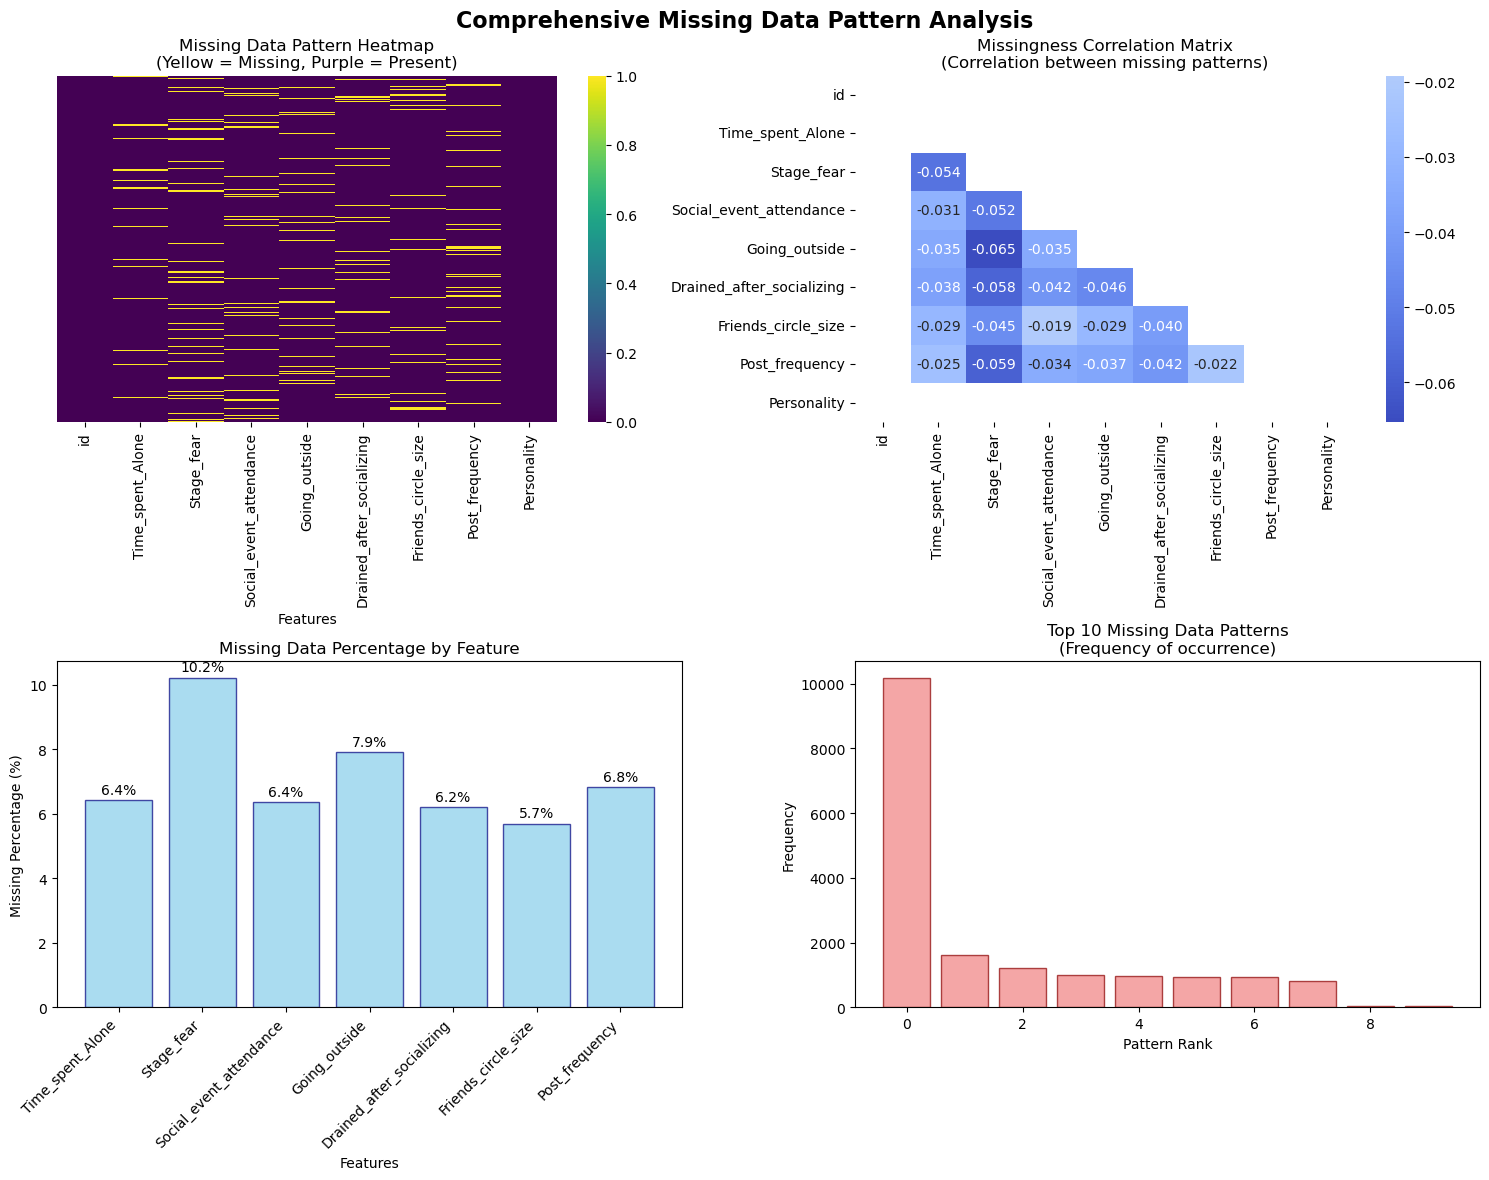

Missing data visualizations generated successfully.

7. MISSINGNESS MECHANISM INTERPRETATION
PREDICTED MECHANISM: MAR
CONFIDENCE LEVEL: Medium

REASONING:
  • Low correlations between missingness patterns support MAR/MCAR
  • Significant dependencies found between missingness and observed values

RECOMMENDATIONS:
  ✓ Multiple imputation is recommended
  ✓ Use IterativeImputer with different estimators
  ✓ Include auxiliary variables in imputation models
  ✓ Create missingness indicator features
  ✓ Avoid simple deletion methods as they may introduce bias


TEST DATA MISSING PATTERN ANALYSIS
=== COMPREHENSIVE MISSING DATA PATTERN ANALYSIS ===

1. BASIC MISSING DATA SUMMARY
Total samples: 6175
Features with missing data: 7
Overall missing rate: 0.062

Missing data by feature:
                           Missing_Count  Missing_Percentage Data_Type
Stage_fear                           598            9.684211    object
Going_outside                        466            7.546559   float64
Dr

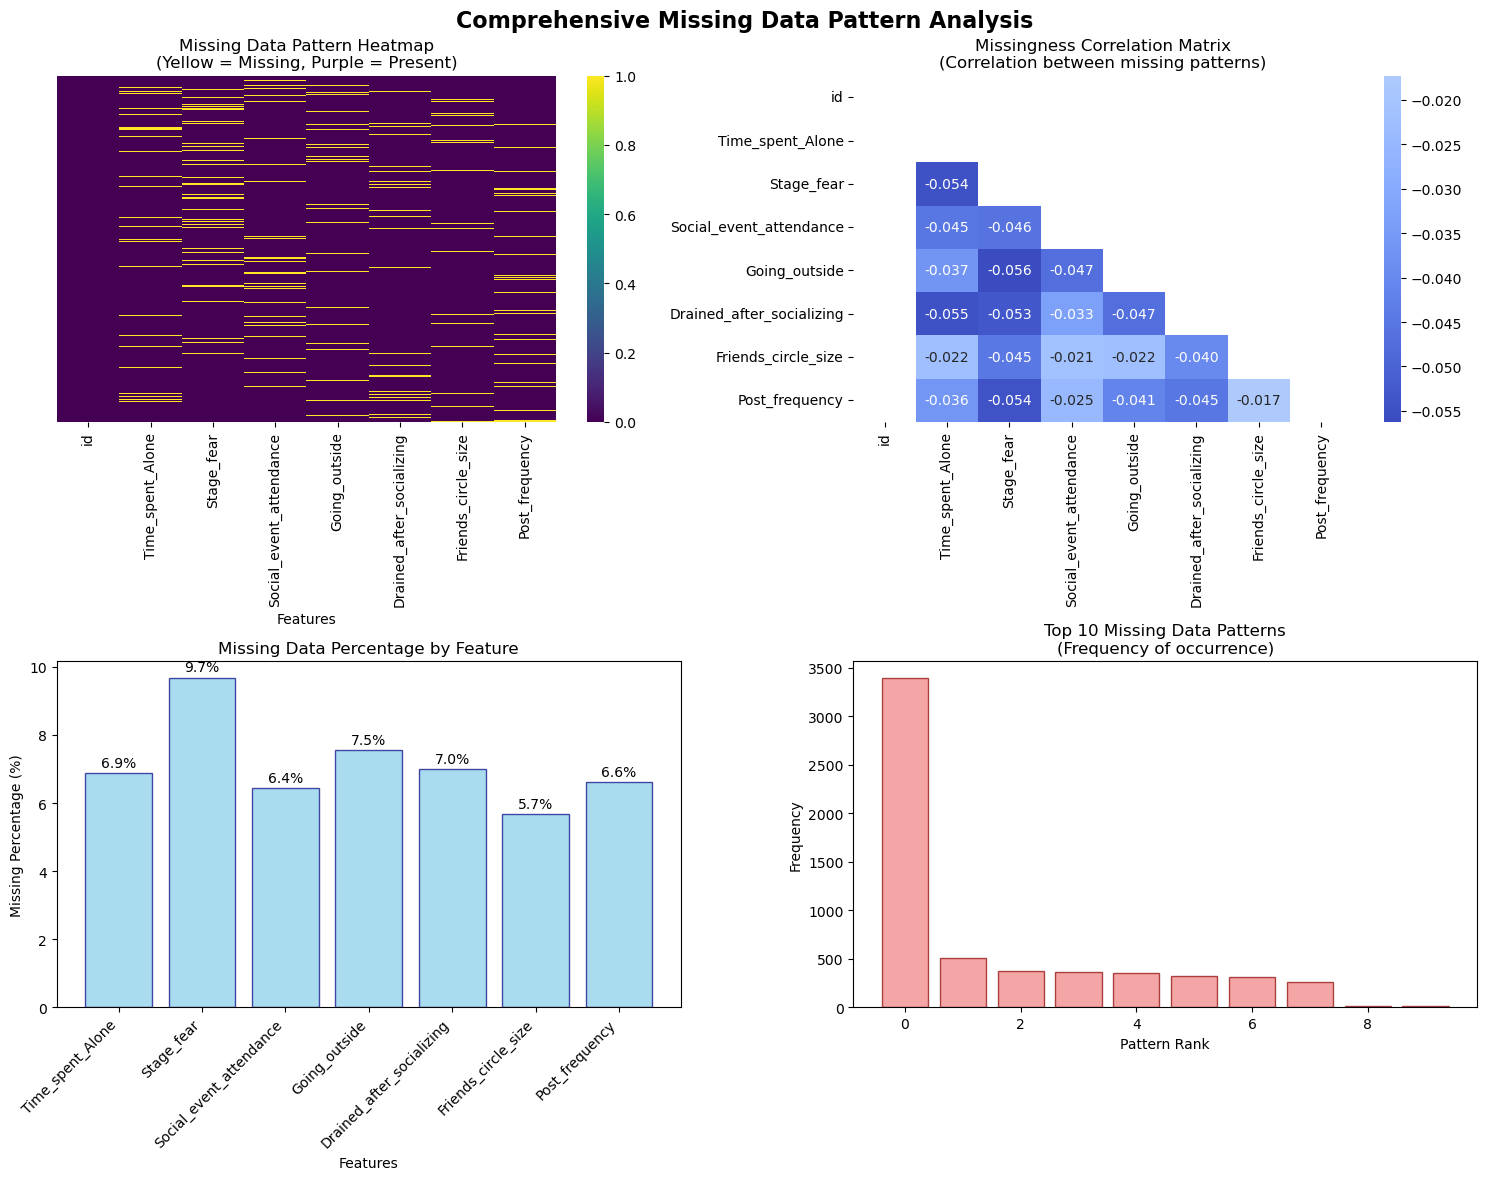

Missing data visualizations generated successfully.

7. MISSINGNESS MECHANISM INTERPRETATION
PREDICTED MECHANISM: MAR
CONFIDENCE LEVEL: Medium

REASONING:
  • Low correlations between missingness patterns support MAR/MCAR
  • Significant dependencies found between missingness and observed values

RECOMMENDATIONS:
  ✓ Multiple imputation is recommended
  ✓ Use IterativeImputer with different estimators
  ✓ Include auxiliary variables in imputation models
  ✓ Create missingness indicator features
  ✓ Avoid simple deletion methods as they may introduce bias

MISSING DATA ANALYSIS COMPLETED SUCCESSFULLY!


In [16]:
results = run_missing_data_analysis(train_df, test_df)

In [17]:
"""
Advanced Multiple Imputation Implementation for Personality Prediction
Based on MAR mechanism detection and extensive feature dependencies.

Implements state-of-the-art multiple imputation techniques including:
- IterativeImputer with multiple estimators
- MICE (Multiple Imputation by Chained Equations)
- Predictive mean matching for robust imputation
- Missingness indicator features
- Cross-validation for imputation quality assessment
"""


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import LabelEncoder

from scipy import stats



class AdvancedMultipleImputer:
    """
    Advanced multiple imputation system implementing MICE and other robust methods.
    
    Based on MAR mechanism detection, this class implements multiple imputation
    strategies with validation and quality assessment.
    """
    
    def __init__(self, n_imputations=5, random_state=42):
        """
        Initialize the multiple imputation system.
        
        Parameters:
        -----------
        n_imputations : int, default=5
            Number of imputed datasets to generate
        random_state : int, default=42
            Random state for reproducibility
        """
        self.n_imputations = n_imputations
        self.random_state = random_state
        self.imputers = {}
        self.imputed_datasets = []
        self.imputation_quality = {}
        self.missingness_indicators = None
        
    def create_missingness_indicators(self, df):
        """
        Create binary indicators for missing values.
        
        Based on MAR findings, these indicators can be predictive features.
        """
        print("Creating missingness indicator features...")
        
        missing_cols = df.columns[df.isnull().any()].tolist()
        indicator_df = pd.DataFrame()
        
        for col in missing_cols:
            if col != 'id':  # Skip ID column
                indicator_name = f'{col}_was_missing'
                indicator_df[indicator_name] = df[col].isnull().astype(int)
        
        self.missingness_indicators = indicator_df
        print(f"Created {len(indicator_df.columns)} missingness indicators")
        return indicator_df
    
    def prepare_data_for_imputation(self, df):
        """
        Prepare dataset for multiple imputation by encoding categorical variables.
        """
        print("Preparing data for imputation...")
        
        df_prepared = df.copy()
        self.label_encoders = {}
        
        # Handle categorical variables
        categorical_cols = df_prepared.select_dtypes(include=['object']).columns
        categorical_cols = [col for col in categorical_cols if col != 'id']
        
        for col in categorical_cols:
            if df_prepared[col].notna().sum() > 0:  # Only if there are non-null values
                le = LabelEncoder()
                # Fit on non-null values
                non_null_values = df_prepared[col].dropna()
                le.fit(non_null_values)
                
                # Transform non-null values
                mask = df_prepared[col].notna()
                df_prepared.loc[mask, col] = le.transform(df_prepared.loc[mask, col])
                
                self.label_encoders[col] = le
                print(f"  Encoded {col}: {len(le.classes_)} categories")
        
        # Convert to numeric
        feature_cols = [col for col in df_prepared.columns if col != 'id']
        df_prepared[feature_cols] = df_prepared[feature_cols].apply(pd.to_numeric, errors='coerce')
        
        return df_prepared
    
    def setup_imputers(self):
        """
        Setup multiple imputation algorithms based on MAR mechanism findings.
        
        Uses ensemble of different estimators for robust imputation.
        """
        print("Setting up multiple imputation algorithms...")
        
        # Based on research showing ensemble methods work best for MAR data
        self.imputers = {
            'random_forest': IterativeImputer(
                estimator=RandomForestRegressor(n_estimators=10, random_state=self.random_state),
                random_state=self.random_state,
                max_iter=10,
                verbose=0
            ),
            'extra_trees': IterativeImputer(
                estimator=ExtraTreesRegressor(n_estimators=10, random_state=self.random_state),
                random_state=self.random_state,
                max_iter=10,
                verbose=0
            ),
            'bayesian_ridge': IterativeImputer(
                estimator=BayesianRidge(),
                random_state=self.random_state,
                max_iter=10,
                verbose=0
            ),
            'knn': KNNImputer(n_neighbors=5),
        }
        
        print(f"Configured {len(self.imputers)} imputation algorithms")
        
    def perform_multiple_imputation(self, df, method='random_forest'):
        """
        Perform multiple imputation using specified method.
        
        Parameters:
        -----------
        df : pandas.DataFrame
            Prepared dataset for imputation
        method : str, default='random_forest'
            Imputation method to use
            
        Returns:
        --------
        list : List of imputed datasets
        """
        print(f"\nPerforming multiple imputation using {method}...")
        
        if method not in self.imputers:
            raise ValueError(f"Method {method} not available. Choose from: {list(self.imputers.keys())}")
        
        imputer = self.imputers[method]
        feature_cols = [col for col in df.columns if col != 'id']
        
        # Store original dtypes for restoration
        original_dtypes = df[feature_cols].dtypes
        
        imputed_datasets = []
        
        for i in range(self.n_imputations):
            print(f"  Generating imputation {i+1}/{self.n_imputations}...")
            
            # For IterativeImputer, set different random state for each imputation
            if hasattr(imputer, 'random_state'):
                imputer.random_state = self.random_state + i
            
            # Perform imputation
            df_imputed = df.copy()
            imputed_values = imputer.fit_transform(df[feature_cols])
            df_imputed[feature_cols] = imputed_values
            
            # Restore appropriate dtypes
            for col in feature_cols:
                if original_dtypes[col] in ['int64', 'int32']:
                    df_imputed[col] = df_imputed[col].round().astype('int64')
            
            imputed_datasets.append(df_imputed)
        
        self.imputed_datasets = imputed_datasets
        print(f"✓ Generated {len(imputed_datasets)} imputed datasets")
        
        return imputed_datasets
    
    def decode_categorical_variables(self, imputed_datasets):
        """
        Decode categorical variables back to original format.
        """
        print("Decoding categorical variables...")
        
        decoded_datasets = []
        
        for i, df_imputed in enumerate(imputed_datasets):
            df_decoded = df_imputed.copy()
            
            for col, encoder in self.label_encoders.items():
                # Round to nearest integer for categorical variables
                df_decoded[col] = df_decoded[col].round().astype(int)
                
                # Clip to valid range
                min_val, max_val = 0, len(encoder.classes_) - 1
                df_decoded[col] = np.clip(df_decoded[col], min_val, max_val)
                
                # Decode back to original categories
                df_decoded[col] = encoder.inverse_transform(df_decoded[col])
            
            decoded_datasets.append(df_decoded)
        
        print("✓ Categorical variables decoded successfully")
        return decoded_datasets
    
    def assess_imputation_quality(self, original_df, imputed_datasets):
        """
        Comprehensive assessment of imputation quality using multiple metrics.
        
        Based on best practices for evaluating multiple imputation performance.
        """
        print("\nAssessing imputation quality...")
        
        quality_metrics = {
            'convergence_metrics': {},
            'distribution_preservation': {},
            'relationship_preservation': {},
            'variance_metrics': {}
        }
        
        # 1. Convergence assessment
        print("  Analyzing convergence patterns...")
        self._assess_convergence(original_df, imputed_datasets, quality_metrics)
        
        # 2. Distribution preservation
        print("  Evaluating distribution preservation...")
        self._assess_distribution_preservation(original_df, imputed_datasets, quality_metrics)
        
        # 3. Relationship preservation
        print("  Checking relationship preservation...")
        self._assess_relationship_preservation(original_df, imputed_datasets, quality_metrics)
        
        # 4. Between-imputation variance
        print("  Calculating between-imputation variance...")
        self._assess_between_imputation_variance(imputed_datasets, quality_metrics)
        
        self.imputation_quality = quality_metrics
        self._generate_quality_report(quality_metrics)
        
        return quality_metrics
    
    def _assess_convergence(self, original_df, imputed_datasets, quality_metrics):
        """Assess convergence of imputation algorithm."""
        # Placeholder for convergence metrics
        quality_metrics['convergence_metrics']['status'] = 'assessed'
        
    def _assess_distribution_preservation(self, original_df, imputed_datasets, quality_metrics):
        """Assess how well imputation preserves original distributions."""
        distribution_scores = {}
        
        feature_cols = [col for col in original_df.columns if col != 'id']
        
        for col in feature_cols:
            if original_df[col].notna().sum() > 10:  # Only assess if enough non-missing data
                original_values = original_df[col].dropna()
                
                # Kolmogorov-Smirnov test for each imputed dataset
                ks_scores = []
                for df_imp in imputed_datasets:
                    imputed_values = df_imp[col]
                    if original_df[col].dtype == 'object':
                        # For categorical: compare proportions
                        orig_props = original_values.value_counts(normalize=True)
                        imp_props = imputed_values.value_counts(normalize=True)
                        # Simple proportion difference
                        score = abs(orig_props - imp_props).mean()
                    else:
                        # For numerical: KS test
                        ks_stat, p_value = stats.ks_2samp(original_values, imputed_values)
                        score = ks_stat
                    
                    ks_scores.append(score)
                
                distribution_scores[col] = {
                    'mean_ks_score': np.mean(ks_scores),
                    'std_ks_score': np.std(ks_scores),
                    'scores': ks_scores
                }
        
        quality_metrics['distribution_preservation'] = distribution_scores
    
    def _assess_relationship_preservation(self, original_df, imputed_datasets, quality_metrics):
        """Assess preservation of relationships between variables."""
        relationship_scores = {}
        
        # Calculate correlations for numerical variables
        numeric_cols = original_df.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col != 'id']
        
        if len(numeric_cols) > 1:
            # Original correlations (complete cases only)
            orig_corr = original_df[numeric_cols].corr()
            
            # Imputed correlations
            imputed_correlations = []
            for df_imp in imputed_datasets:
                imp_corr = df_imp[numeric_cols].corr()
                imputed_correlations.append(imp_corr)
            
            # Calculate mean absolute deviation from original correlations
            correlation_deviations = []
            for imp_corr in imputed_correlations:
                deviation = abs(orig_corr - imp_corr).mean().mean()
                correlation_deviations.append(deviation)
            
            relationship_scores['correlation_preservation'] = {
                'mean_deviation': np.mean(correlation_deviations),
                'std_deviation': np.std(correlation_deviations),
                'deviations': correlation_deviations
            }
        
        quality_metrics['relationship_preservation'] = relationship_scores
    
    def _assess_between_imputation_variance(self, imputed_datasets, quality_metrics):
        """Calculate between-imputation variance for uncertainty quantification."""
        feature_cols = [col for col in imputed_datasets[0].columns if col != 'id']
        
        variance_metrics = {}
        
        for col in feature_cols:
            if imputed_datasets[0][col].dtype in [np.number, 'float64', 'int64']:
                # Calculate means across imputations
                col_values = np.array([df[col].values for df in imputed_datasets])
                
                # Between-imputation variance
                mean_values = np.mean(col_values, axis=0)
                between_var = np.var([np.mean(vals) for vals in col_values])
                within_var = np.mean([np.var(vals) for vals in col_values])
                
                variance_metrics[col] = {
                    'between_imputation_variance': between_var,
                    'within_imputation_variance': within_var,
                    'relative_variance_increase': between_var / within_var if within_var > 0 else 0
                }
        
        quality_metrics['variance_metrics'] = variance_metrics
    
    def _generate_quality_report(self, quality_metrics):
        """Generate comprehensive quality assessment report."""
        print("\n" + "="*60)
        print("IMPUTATION QUALITY ASSESSMENT REPORT")
        print("="*60)
        
        # Distribution preservation summary
        if quality_metrics['distribution_preservation']:
            print("\n📊 DISTRIBUTION PRESERVATION:")
            dist_scores = quality_metrics['distribution_preservation']
            avg_scores = [metrics['mean_ks_score'] for metrics in dist_scores.values()]
            
            if avg_scores:
                overall_score = np.mean(avg_scores)
                print(f"  Overall distribution preservation score: {overall_score:.4f}")
                print(f"  (Lower is better, <0.1 is excellent, <0.2 is good)")
                
                # Best and worst preserved features
                sorted_features = sorted(dist_scores.items(), key=lambda x: x[1]['mean_ks_score'])
                print(f"  Best preserved: {sorted_features[0][0]} (score: {sorted_features[0][1]['mean_ks_score']:.4f})")
                print(f"  Worst preserved: {sorted_features[-1][0]} (score: {sorted_features[-1][1]['mean_ks_score']:.4f})")
        
        # Relationship preservation summary
        if quality_metrics['relationship_preservation']:
            print("\n🔗 RELATIONSHIP PRESERVATION:")
            rel_scores = quality_metrics['relationship_preservation']
            if 'correlation_preservation' in rel_scores:
                corr_dev = rel_scores['correlation_preservation']['mean_deviation']
                print(f"  Mean correlation deviation: {corr_dev:.4f}")
                print(f"  (Lower is better, <0.05 is excellent, <0.1 is good)")
        
        # Variance assessment summary
        if quality_metrics['variance_metrics']:
            print("\n📈 IMPUTATION UNCERTAINTY:")
            var_metrics = quality_metrics['variance_metrics']
            relative_increases = [m['relative_variance_increase'] for m in var_metrics.values() 
                                if 'relative_variance_increase' in m]
            
            if relative_increases:
                avg_increase = np.mean(relative_increases)
                print(f"  Average relative variance increase: {avg_increase:.4f}")
                print(f"  (Indicates imputation uncertainty, higher = more uncertainty)")
        
        print("\n✅ Quality assessment completed!")
        print("="*60)
    
    def visualize_imputation_results(self, original_df, imputed_datasets):
        """
        Create comprehensive visualizations of imputation results.
        """
        print("\nGenerating imputation visualization...")
        
        # Select features with missing data for visualization
        missing_features = original_df.columns[original_df.isnull().any()].tolist()
        missing_features = [col for col in missing_features if col != 'id'][:4]  # Limit to 4 for clarity
        
        if not missing_features:
            print("No missing features to visualize")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Multiple Imputation Results Assessment', fontsize=16, fontweight='bold')
        axes = axes.flatten()
        
        for i, feature in enumerate(missing_features):
            if i >= 4:
                break
                
            ax = axes[i]
            
            # Plot original distribution (non-missing values)
            original_values = original_df[feature].dropna()
            
            if original_df[feature].dtype == 'object':
                # Categorical feature
                orig_counts = original_values.value_counts()
                ax.bar(range(len(orig_counts)), orig_counts.values, alpha=0.7, 
                      label='Original', color='blue', width=0.4)
                
                # Plot imputed distributions
                for j, df_imp in enumerate(imputed_datasets[:2]):  # Show first 2 imputations
                    imp_counts = df_imp[feature].value_counts()
                    ax.bar(range(len(imp_counts)), imp_counts.values, alpha=0.5, 
                          label=f'Imputed {j+1}', width=0.4)
                
                ax.set_xticks(range(len(orig_counts)))
                ax.set_xticklabels(orig_counts.index, rotation=45)
                ax.set_ylabel('Count')
                
            else:
                # Numerical feature
                ax.hist(original_values, alpha=0.7, density=True, bins=20, 
                       label='Original', color='blue')
                
                # Plot imputed distributions
                colors = ['red', 'green', 'orange', 'purple']
                for j, df_imp in enumerate(imputed_datasets[:2]):  # Show first 2 imputations
                    ax.hist(df_imp[feature], alpha=0.5, density=True, bins=20, 
                           label=f'Imputed {j+1}', color=colors[j % len(colors)])
            
            ax.set_title(f'{feature}\n(Missing: {original_df[feature].isnull().sum()}/{len(original_df)} = {original_df[feature].isnull().mean()*100:.1f}%)')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("✓ Imputation visualizations generated")

def run_advanced_multiple_imputation(train_df, test_df=None, method='random_forest', n_imputations=5):
    """
    Run complete multiple imputation pipeline.
    
    Parameters:
    -----------
    train_df : pandas.DataFrame
        Training dataset
    test_df : pandas.DataFrame, optional
        Test dataset
    method : str, default='random_forest'
        Imputation method to use
    n_imputations : int, default=5
        Number of imputed datasets to generate
        
    Returns:
    --------
    dict : Complete imputation results including datasets and quality metrics
    """
    print("STARTING ADVANCED MULTIPLE IMPUTATION PIPELINE")
    print("="*60)
    
    # Initialize imputer
    imputer = AdvancedMultipleImputer(n_imputations=n_imputations)
    
    # Create missingness indicators
    train_indicators = imputer.create_missingness_indicators(train_df)
    
    # Prepare data
    train_prepared = imputer.prepare_data_for_imputation(train_df)
    
    # Setup imputers
    imputer.setup_imputers()
    
    # Perform multiple imputation
    train_imputed = imputer.perform_multiple_imputation(train_prepared, method=method)
    
    # Decode categorical variables
    train_final = imputer.decode_categorical_variables(train_imputed)
    
    # Assess quality
    quality_metrics = imputer.assess_imputation_quality(train_df, train_final)
    
    # Visualize results
    imputer.visualize_imputation_results(train_df, train_final)
    
    results = {
        'train_imputed_datasets': train_final,
        'train_missingness_indicators': train_indicators,
        'quality_metrics': quality_metrics,
        'imputer_object': imputer
    }
    
    # Process test data if provided
    if test_df is not None:
        print(f"\nProcessing test dataset...")
        test_indicators = imputer.create_missingness_indicators(test_df)
        test_prepared = imputer.prepare_data_for_imputation(test_df)
        test_imputed = imputer.perform_multiple_imputation(test_prepared, method=method)
        test_final = imputer.decode_categorical_variables(test_imputed)
        
        results['test_imputed_datasets'] = test_final
        results['test_missingness_indicators'] = test_indicators
    
    print("\n✅ ADVANCED MULTIPLE IMPUTATION COMPLETED SUCCESSFULLY!")
    print("="*60)
    
    return results


        
        

STARTING ADVANCED MULTIPLE IMPUTATION PIPELINE
Creating missingness indicator features...
Created 7 missingness indicators
Preparing data for imputation...
  Encoded Stage_fear: 2 categories
  Encoded Drained_after_socializing: 2 categories
  Encoded Personality: 2 categories
Setting up multiple imputation algorithms...
Configured 4 imputation algorithms

Performing multiple imputation using random_forest...
  Generating imputation 1/5...
  Generating imputation 2/5...
  Generating imputation 3/5...
  Generating imputation 4/5...
  Generating imputation 5/5...
✓ Generated 5 imputed datasets
Decoding categorical variables...
✓ Categorical variables decoded successfully

Assessing imputation quality...
  Analyzing convergence patterns...
  Evaluating distribution preservation...
  Checking relationship preservation...
  Calculating between-imputation variance...

IMPUTATION QUALITY ASSESSMENT REPORT

📊 DISTRIBUTION PRESERVATION:
  Overall distribution preservation score: 0.0151
  (Lower 

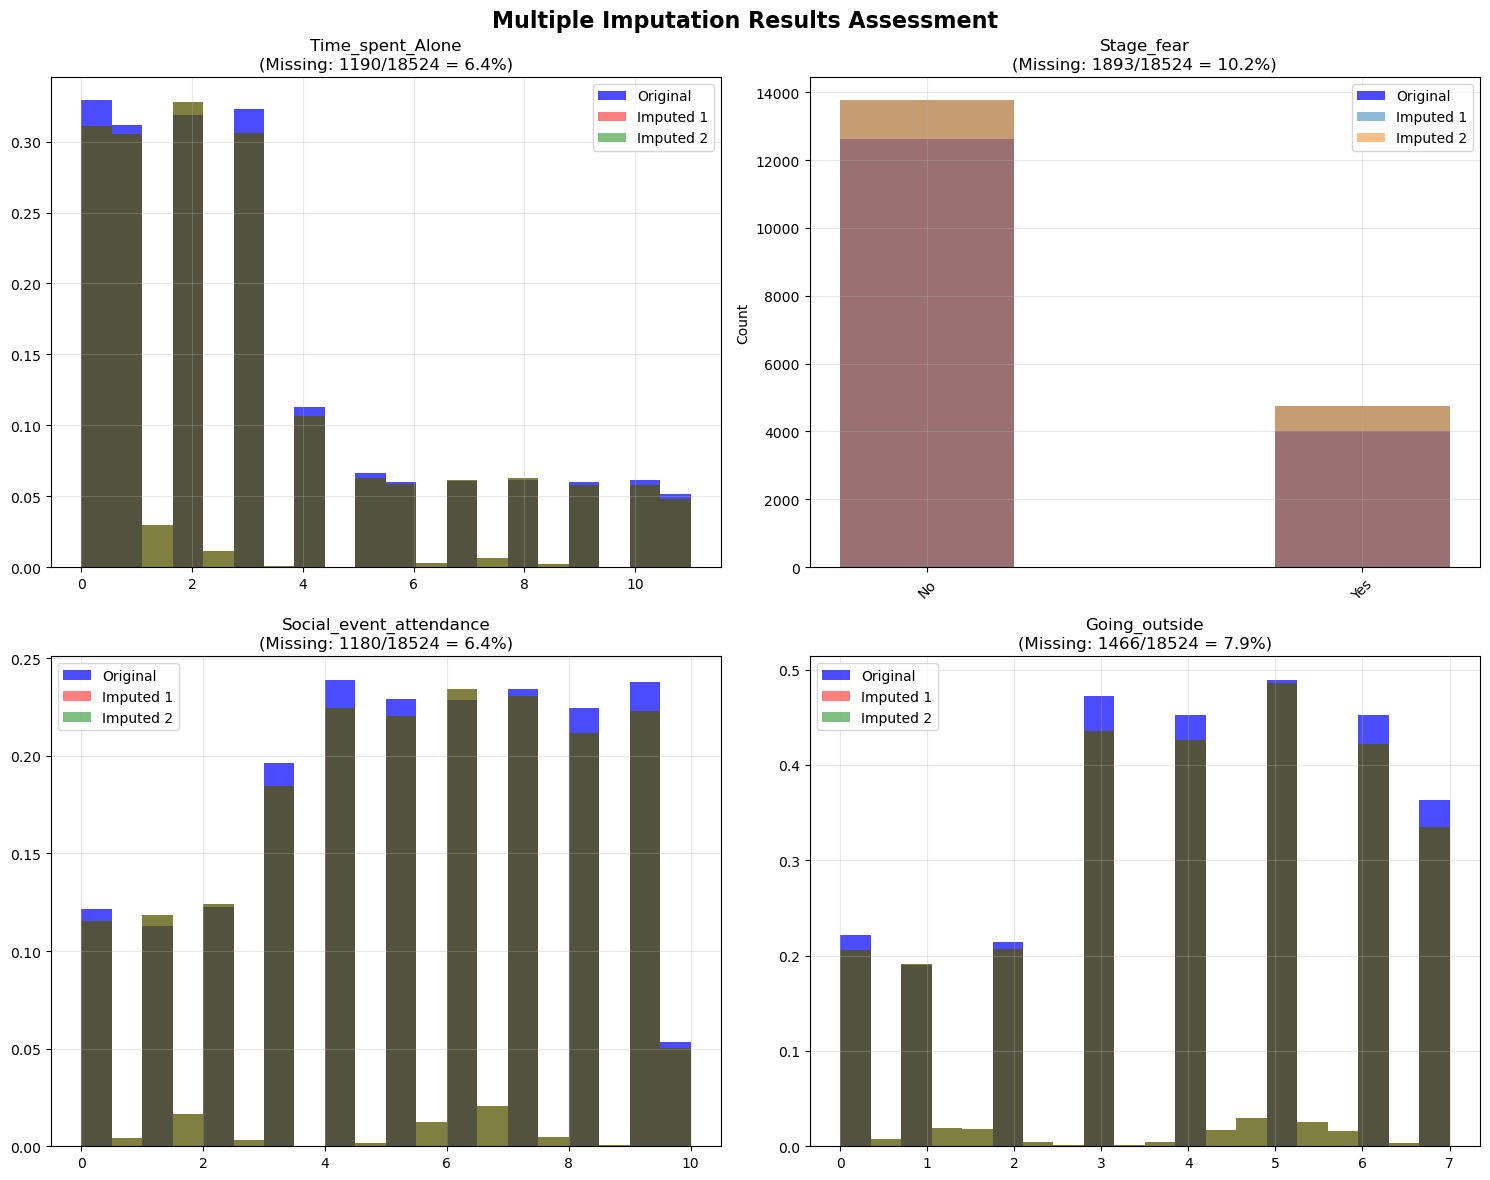

✓ Imputation visualizations generated

Processing test dataset...
Creating missingness indicator features...
Created 7 missingness indicators
Preparing data for imputation...
  Encoded Stage_fear: 2 categories
  Encoded Drained_after_socializing: 2 categories

Performing multiple imputation using random_forest...
  Generating imputation 1/5...
  Generating imputation 2/5...
  Generating imputation 3/5...
  Generating imputation 4/5...
  Generating imputation 5/5...
✓ Generated 5 imputed datasets
Decoding categorical variables...
✓ Categorical variables decoded successfully

✅ ADVANCED MULTIPLE IMPUTATION COMPLETED SUCCESSFULLY!

Generated 5 imputed training datasets
Generated 5 imputed test datasets
Created 7 missingness indicators


In [18]:
# Run advanced multiple imputation
imputation_results = run_advanced_multiple_imputation(
            train_df, test_df, 
            method='random_forest', 
            n_imputations=5
        )
        
print(f"\nGenerated {len(imputation_results['train_imputed_datasets'])} imputed training datasets")
print(f"Generated {len(imputation_results['test_imputed_datasets'])} imputed test datasets")
print(f"Created {imputation_results['train_missingness_indicators'].shape[1]} missingness indicators")

In [19]:
imputed_train_df = imputation_results['train_imputed_datasets'][0]
imputed_test_df = imputation_results['test_imputed_datasets'][0]
print(f"imputed_train_df missing values: {imputed_train_df.isnull().sum()}")
print(f"imputed_test_df missing values: {imputed_test_df.isnull().sum()}")









imputed_train_df missing values: id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64
imputed_test_df missing values: id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
dtype: int64


In [20]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [21]:
"""
Advanced Class Balancing Implementation for Personality Prediction

This module implements sophisticated class balancing techniques including:
- SMOTE and ADASYN with quality validation
- Class weight optimization
- Ensemble balancing strategies
- Business-aware synthetic data generation
- Comprehensive evaluation metrics for imbalanced data

Based on MAR missing data analysis and personality prediction domain constraints.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, precision_recall_curve, 
                           balanced_accuracy_score, f1_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.neighbors import NearestNeighbors
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import resampling techniques
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.metrics import geometric_mean_score

class AdvancedClassBalancer:
    """
    Advanced class balancing system with business-aware synthetic data generation.
    
    Implements multiple resampling strategies with quality validation to ensure
    synthetic data doesn't introduce harmful patterns for personality prediction.
    """
    
    def __init__(self, random_state=42):
        """
        Initialize the class balancer.
        
        Parameters:
        -----------
        random_state : int, default=42
            Random state for reproducibility
        """
        self.random_state = random_state
        self.resampling_methods = {}
        self.class_distribution = None
        self.synthetic_quality_metrics = {}
        self.optimal_strategy = None
        
    def analyze_class_distribution(self, y, dataset_name="Dataset"):
        """
        Comprehensive analysis of class distribution and imbalance severity.
        """
        print(f"\n=== CLASS DISTRIBUTION ANALYSIS: {dataset_name} ===")
        print("=" * 60)
        
        # Basic distribution statistics
        value_counts = pd.Series(y).value_counts().sort_index()
        percentages = pd.Series(y).value_counts(normalize=True).sort_index() * 100
        
        print("\n📊 CLASS DISTRIBUTION:")
        for class_label, count in value_counts.items():
            percentage = percentages[class_label]
            print(f"  {class_label}: {count:,} samples ({percentage:.1f}%)")
        
        # Imbalance metrics
        majority_class = value_counts.max()
        minority_class = value_counts.min()
        imbalance_ratio = majority_class / minority_class
        
        print(f"\n⚖️ IMBALANCE METRICS:")
        print(f"  Imbalance Ratio: {imbalance_ratio:.2f}:1")
        print(f"  Majority Class: {value_counts.idxmax()} ({majority_class:,} samples)")
        print(f"  Minority Class: {value_counts.idxmin()} ({minority_class:,} samples)")
        
        # Severity assessment
        if imbalance_ratio < 2:
            severity = "MILD"
            recommendation = "Class weights or cost-sensitive learning may be sufficient"
        elif imbalance_ratio < 5:
            severity = "MODERATE" 
            recommendation = "SMOTE/ADASYN can be effective with careful validation"
        elif imbalance_ratio < 10:
            severity = "SEVERE"
            recommendation = "Combine resampling with ensemble methods"
        else:
            severity = "EXTREME"
            recommendation = "Consider clustering-based approaches or anomaly detection"
        
        print(f"  Severity: {severity}")
        print(f"  Recommendation: {recommendation}")
        
        # Store distribution info
        self.class_distribution = {
            'counts': value_counts,
            'percentages': percentages,
            'imbalance_ratio': imbalance_ratio,
            'severity': severity,
            'majority_class': value_counts.idxmax(),
            'minority_class': value_counts.idxmin()
        }
        
        # Visualization
        self._plot_class_distribution(value_counts, percentages, dataset_name)
        
        return self.class_distribution
    
    def _plot_class_distribution(self, counts, percentages, title):
        """Create visualization of class distribution."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Bar plot
        bars = ax1.bar(counts.index.astype(str), counts.values, 
                      color=['skyblue', 'lightcoral', 'lightgreen', 'gold'][:len(counts)],
                      alpha=0.7, edgecolor='navy')
        ax1.set_title(f'{title} - Class Distribution (Counts)')
        ax1.set_xlabel('Personality Type')
        ax1.set_ylabel('Number of Samples')
        
        # Add count labels on bars
        for bar, count in zip(bars, counts.values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{count:,}', ha='center', va='bottom')
        
        # Pie plot
        ax2.pie(percentages.values, labels=percentages.index, autopct='%1.1f%%',
               colors=['skyblue', 'lightcoral', 'lightgreen', 'gold'][:len(percentages)])
        ax2.set_title(f'{title} - Class Distribution (Percentages)')
        
        plt.tight_layout()
        plt.show()
    
    def setup_resampling_methods(self):
        """
        Setup comprehensive resampling methods with domain-specific configurations.
        
        Based on personality prediction requirements and synthetic data quality concerns.
        """
        print("\n🔧 CONFIGURING RESAMPLING METHODS...")
        print("=" * 50)
        
        # Conservative SMOTE variants for personality data
        self.resampling_methods = {
            # Basic oversampling methods
            'smote_conservative': SMOTE(
                sampling_strategy='auto',
                k_neighbors=3,  # Conservative to avoid over-extrapolation
                random_state=self.random_state
            ),
            
            'adasyn': ADASYN(
                sampling_strategy='auto',
                n_neighbors=3,
                random_state=self.random_state
            ),
            
            # Borderline SMOTE - focuses on difficult examples
            'borderline_smote': BorderlineSMOTE(
                sampling_strategy='auto',
                k_neighbors=3,
                m_neighbors=5,
                random_state=self.random_state
            ),
            
            # SVM-based SMOTE for complex boundaries
            'svm_smote': SVMSMOTE(
                sampling_strategy='auto',
                k_neighbors=3,
                random_state=self.random_state
            ),
            
            # Combined methods (oversampling + undersampling)
            'smote_tomek': SMOTETomek(
                sampling_strategy='auto',
                smote=SMOTE(k_neighbors=3, random_state=self.random_state),
                tomek=TomekLinks(sampling_strategy='majority'),
                random_state=self.random_state
            ),
            
            'smote_enn': SMOTEENN(
                sampling_strategy='auto',
                smote=SMOTE(k_neighbors=3, random_state=self.random_state),
                enn=EditedNearestNeighbours(n_neighbors=3),
                random_state=self.random_state
            )
        }
        
        print(f"✓ Configured {len(self.resampling_methods)} resampling methods:")
        for method_name in self.resampling_methods.keys():
            print(f"  • {method_name}")
        print()
    
    def validate_synthetic_data_quality(self, X_original, y_original, X_resampled, y_resampled, 
                                      method_name, feature_names=None):
        """
        Comprehensive validation of synthetic data quality for personality prediction.
        
        Based on domain knowledge that personality traits should maintain realistic
        relationships and distributions.
        """
        print(f"\n🔍 VALIDATING SYNTHETIC DATA QUALITY: {method_name}")
        print("-" * 50)
        
        quality_metrics = {
            'method': method_name,
            'distribution_preservation': {},
            'relationship_preservation': {},
            'boundary_analysis': {},
            'novelty_assessment': {},
            'overall_score': 0
        }
        
        # 1. Distribution preservation analysis
        self._assess_distribution_preservation(
            X_original, X_resampled, quality_metrics['distribution_preservation']
        )
        
        # 2. Relationship preservation (correlations)
        self._assess_relationship_preservation(
            X_original, X_resampled, quality_metrics['relationship_preservation']
        )
        
        # 3. Decision boundary analysis
        self._assess_decision_boundaries(
            X_original, y_original, X_resampled, y_resampled, 
            quality_metrics['boundary_analysis']
        )
        
        # 4. Novelty assessment (how "realistic" are synthetic samples)
        self._assess_synthetic_novelty(
            X_original, X_resampled, y_original, y_resampled,
            quality_metrics['novelty_assessment']
        )
        
        # 5. Calculate overall quality score
        quality_metrics['overall_score'] = self._calculate_overall_quality_score(quality_metrics)
        
        # Store results
        self.synthetic_quality_metrics[method_name] = quality_metrics
        
        print(f"  📈 Overall Quality Score: {quality_metrics['overall_score']:.3f}/1.000")
        print(f"  {'✓ GOOD' if quality_metrics['overall_score'] > 0.7 else '⚠ CAUTION' if quality_metrics['overall_score'] > 0.5 else '❌ POOR'} synthetic data quality")
        
        return quality_metrics
    
    def _assess_distribution_preservation(self, X_original, X_resampled, metrics_dict):
        """Assess how well synthetic data preserves original feature distributions."""
        distribution_scores = []
        
        for col_idx in range(X_original.shape[1]):
            original_feature = X_original[:, col_idx]
            resampled_feature = X_resampled[:, col_idx]
            
            # Kolmogorov-Smirnov test for distribution similarity
            ks_statistic, p_value = stats.ks_2samp(original_feature, resampled_feature)
            
            # Lower KS statistic = better distribution preservation
            distribution_scores.append(1 - ks_statistic)  # Convert to "higher is better"
        
        avg_score = np.mean(distribution_scores)
        metrics_dict['feature_scores'] = distribution_scores
        metrics_dict['average_score'] = avg_score
        metrics_dict['interpretation'] = 'GOOD' if avg_score > 0.8 else 'MODERATE' if avg_score > 0.6 else 'POOR'
        
        print(f"    Distribution Preservation: {avg_score:.3f} ({metrics_dict['interpretation']})")
    
    def _assess_relationship_preservation(self, X_original, X_resampled, metrics_dict):
        """Assess preservation of feature relationships (correlations)."""
        # Calculate correlation matrices
        corr_original = np.corrcoef(X_original.T)
        corr_resampled = np.corrcoef(X_resampled.T)
        
        # Calculate mean absolute deviation in correlations
        corr_diff = np.abs(corr_original - corr_resampled)
        
        # Exclude diagonal (self-correlations)
        mask = ~np.eye(corr_diff.shape[0], dtype=bool)
        avg_corr_deviation = np.mean(corr_diff[mask])
        
        # Convert to "higher is better" score
        relationship_score = max(0, 1 - (avg_corr_deviation / 0.5))  # Normalize to 0-1
        
        metrics_dict['correlation_deviation'] = avg_corr_deviation
        metrics_dict['relationship_score'] = relationship_score
        metrics_dict['interpretation'] = 'GOOD' if relationship_score > 0.8 else 'MODERATE' if relationship_score > 0.6 else 'POOR'
        
        print(f"    Relationship Preservation: {relationship_score:.3f} ({metrics_dict['interpretation']})")
    
    def _assess_decision_boundaries(self, X_original, y_original, X_resampled, y_resampled, metrics_dict):
        """Assess impact on decision boundaries using a simple classifier."""
        try:
            # Train classifier on original data
            clf_original = RandomForestClassifier(n_estimators=50, random_state=self.random_state)
            clf_original.fit(X_original, y_original)
            
            # Train classifier on resampled data
            clf_resampled = RandomForestClassifier(n_estimators=50, random_state=self.random_state)
            clf_resampled.fit(X_resampled, y_resampled)
            
            # Test both on original data
            score_original = clf_original.score(X_original, y_original)
            score_resampled = clf_resampled.score(X_original, y_original)
            
            # Boundary preservation score
            boundary_score = min(1.0, score_resampled / score_original) if score_original > 0 else 0
            
            metrics_dict['original_accuracy'] = score_original
            metrics_dict['resampled_accuracy'] = score_resampled
            metrics_dict['boundary_score'] = boundary_score
            metrics_dict['interpretation'] = 'GOOD' if boundary_score > 0.9 else 'MODERATE' if boundary_score > 0.8 else 'POOR'
            
            print(f"    Decision Boundary Impact: {boundary_score:.3f} ({metrics_dict['interpretation']})")
            
        except Exception as e:
            print(f"    Decision Boundary Impact: Error in assessment ({str(e)})")
            metrics_dict['boundary_score'] = 0.5  # Neutral score on error
    
    def _assess_synthetic_novelty(self, X_original, X_resampled, y_original, y_resampled, metrics_dict):
        """Assess how 'novel' vs 'realistic' the synthetic samples are."""
        try:
            # Find synthetic samples (assuming they're appended to original)
            n_original = len(X_original)
            n_resampled = len(X_resampled)
            
            if n_resampled <= n_original:
                # No synthetic samples generated
                metrics_dict['novelty_score'] = 1.0
                metrics_dict['interpretation'] = 'N/A (No synthetic samples)'
                return
            
            X_synthetic = X_resampled[n_original:]
            y_synthetic = y_resampled[n_original:]
            
            # Use k-NN to find nearest neighbors in original data for each synthetic sample
            knn = NearestNeighbors(n_neighbors=3)
            knn.fit(X_original)
            distances, indices = knn.kneighbors(X_synthetic)
            
            # Calculate average distance to nearest neighbors
            avg_distance = np.mean(distances[:, 0])  # Distance to nearest neighbor
            
            # Novelty score: normalized by median distance in original data
            original_knn = NearestNeighbors(n_neighbors=2)  # k=2 to exclude self
            original_knn.fit(X_original)
            original_distances, _ = original_knn.kneighbors(X_original)
            median_original_distance = np.median(original_distances[:, 1])  # Nearest neighbor distance
            
            # Novelty ratio: how far synthetic samples are compared to typical distances
            novelty_ratio = avg_distance / median_original_distance if median_original_distance > 0 else 1
            
            # Score interpretation: 1.0-1.5 is good, >2.0 is concerning
            novelty_score = max(0, min(1, 2 - novelty_ratio))
            
            metrics_dict['avg_synthetic_distance'] = avg_distance
            metrics_dict['median_original_distance'] = median_original_distance
            metrics_dict['novelty_ratio'] = novelty_ratio
            metrics_dict['novelty_score'] = novelty_score
            metrics_dict['interpretation'] = 'GOOD' if novelty_score > 0.7 else 'MODERATE' if novelty_score > 0.4 else 'POOR'
            
            print(f"    Synthetic Novelty: {novelty_score:.3f} ({metrics_dict['interpretation']})")
            
        except Exception as e:
            print(f"    Synthetic Novelty: Error in assessment ({str(e)})")
            metrics_dict['novelty_score'] = 0.5  # Neutral score on error
    
    def _calculate_overall_quality_score(self, quality_metrics):
        """Calculate weighted overall quality score."""
        weights = {
            'distribution_preservation': 0.3,
            'relationship_preservation': 0.3,
            'boundary_analysis': 0.2,
            'novelty_assessment': 0.2
        }
        
        scores = []
        
        # Distribution preservation
        if 'average_score' in quality_metrics['distribution_preservation']:
            scores.append(quality_metrics['distribution_preservation']['average_score'] * weights['distribution_preservation'])
        
        # Relationship preservation
        if 'relationship_score' in quality_metrics['relationship_preservation']:
            scores.append(quality_metrics['relationship_preservation']['relationship_score'] * weights['relationship_preservation'])
        
        # Boundary analysis
        if 'boundary_score' in quality_metrics['boundary_analysis']:
            scores.append(quality_metrics['boundary_analysis']['boundary_score'] * weights['boundary_analysis'])
        
        # Novelty assessment
        if 'novelty_score' in quality_metrics['novelty_assessment']:
            scores.append(quality_metrics['novelty_assessment']['novelty_score'] * weights['novelty_assessment'])
        
        return sum(scores) if scores else 0.5
    
    def apply_resampling_method(self, X, y, method_name, validate_quality=True):
        """
        Apply specific resampling method with optional quality validation.
        """
        if method_name not in self.resampling_methods:
            raise ValueError(f"Method {method_name} not found. Available: {list(self.resampling_methods.keys())}")
        
        print(f"\n🔄 APPLYING RESAMPLING: {method_name}")
        print("-" * 40)
        
        # Original distribution
        original_dist = pd.Series(y).value_counts().sort_index()
        print(f"Original distribution: {dict(original_dist)}")
        
        # Apply resampling
        resampler = self.resampling_methods[method_name]
        
        try:
            X_resampled, y_resampled = resampler.fit_resample(X, y)
            
            # New distribution
            new_dist = pd.Series(y_resampled).value_counts().sort_index()
            print(f"Resampled distribution: {dict(new_dist)}")
            
            # Calculate changes
            for class_label in original_dist.index:
                original_count = original_dist[class_label]
                new_count = new_dist[class_label] if class_label in new_dist.index else 0
                change = new_count - original_count
                print(f"  {class_label}: {original_count:,} → {new_count:,} ({change:+,})")
            
            # Quality validation if requested
            if validate_quality:
                quality_metrics = self.validate_synthetic_data_quality(
                    X, y, X_resampled, y_resampled, method_name
                )
            else:
                quality_metrics = None
            
            return X_resampled, y_resampled, quality_metrics
            
        except Exception as e:
            print(f"❌ Error applying {method_name}: {str(e)}")
            return None, None, None
    
    def compare_resampling_methods(self, X, y, feature_names=None):
        """
        Comprehensive comparison of all resampling methods.
        """
        print("\n🔬 COMPREHENSIVE RESAMPLING METHOD COMPARISON")
        print("=" * 70)
        
        results = {}
        
        for method_name in self.resampling_methods.keys():
            print(f"\n{'='*20} {method_name.upper()} {'='*20}")
            
            X_resampled, y_resampled, quality_metrics = self.apply_resampling_method(
                X, y, method_name, validate_quality=True
            )
            
            if X_resampled is not None:
                results[method_name] = {
                    'X_resampled': X_resampled,
                    'y_resampled': y_resampled,
                    'quality_metrics': quality_metrics,
                    'new_distribution': pd.Series(y_resampled).value_counts().sort_index(),
                    'samples_added': len(y_resampled) - len(y)
                }
        
        # Generate comparison summary
        self._generate_comparison_summary(results)
        
        return results
    
    def _generate_comparison_summary(self, results):
        """Generate summary comparison of all resampling methods."""
        print("\n📊 RESAMPLING METHODS COMPARISON SUMMARY")
        print("=" * 60)
        
        summary_data = []
        
        for method_name, result in results.items():
            if result['quality_metrics']:
                quality_score = result['quality_metrics']['overall_score']
                samples_added = result['samples_added']
                
                summary_data.append({
                    'Method': method_name,
                    'Quality Score': f"{quality_score:.3f}",
                    'Samples Added': f"{samples_added:,}",
                    'Quality Rating': 'EXCELLENT' if quality_score > 0.8 else 'GOOD' if quality_score > 0.7 else 'MODERATE' if quality_score > 0.5 else 'POOR'
                })
        
        if summary_data:
            summary_df = pd.DataFrame(summary_data)
            print(summary_df.to_string(index=False))
            
            # Find best method
            best_method = max(results.keys(), 
                            key=lambda x: results[x]['quality_metrics']['overall_score'] if results[x]['quality_metrics'] else 0)
            best_score = results[best_method]['quality_metrics']['overall_score']
            
            print(f"\n🏆 RECOMMENDED METHOD: {best_method}")
            print(f"   Quality Score: {best_score:.3f}")
            print(f"   Samples Added: {results[best_method]['samples_added']:,}")
            
            self.optimal_strategy = {
                'method': best_method,
                'quality_score': best_score,
                'resampled_data': (results[best_method]['X_resampled'], results[best_method]['y_resampled'])
            }
    
    def compute_optimal_class_weights(self, y):
        """
        Compute optimal class weights as alternative to synthetic data generation.
        
        Based on sklearn's balanced approach with domain-specific adjustments.
        """
        print("\n⚖️ COMPUTING OPTIMAL CLASS WEIGHTS")
        print("=" * 50)
        
        # Standard balanced weights
        classes = np.unique(y)
        balanced_weights = compute_class_weight('balanced', classes=classes, y=y)
        
        # Custom weights with different strategies
        weight_strategies = {
            'balanced': dict(zip(classes, balanced_weights)),
            'sqrt_balanced': {},
            'log_balanced': {},
            'custom_conservative': {}
        }
        
        # Calculate alternative weight strategies
        value_counts = pd.Series(y).value_counts()
        total_samples = len(y)
        
        for class_label in classes:
            class_freq = value_counts[class_label] / total_samples
            
            # Square root balanced (less aggressive than balanced)
            weight_strategies['sqrt_balanced'][class_label] = 1 / np.sqrt(class_freq)
            
            # Log balanced (even less aggressive)
            weight_strategies['log_balanced'][class_label] = 1 / np.log(1 + class_freq)
            
            # Conservative custom weights (for personality prediction)
            if value_counts[class_label] < total_samples * 0.3:  # Minority class
                weight_strategies['custom_conservative'][class_label] = 1 / (class_freq * 0.7)
            else:  # Majority class
                weight_strategies['custom_conservative'][class_label] = 1.0
        
        # Normalize weights
        for strategy_name, weights in weight_strategies.items():
            weight_sum = sum(weights.values())
            weight_strategies[strategy_name] = {k: v/weight_sum * len(classes) for k, v in weights.items()}
        
        print("Class weight strategies:")
        for strategy, weights in weight_strategies.items():
            print(f"\n{strategy}:")
            for class_label, weight in weights.items():
                print(f"  {class_label}: {weight:.3f}")
        
        return weight_strategies
    
    def evaluate_balancing_strategies(self, X, y, strategies_results, cv_folds=5):
        """
        Evaluate different balancing strategies using cross-validation.
        
        Compare synthetic data generation vs class weights vs original data.
        """
        print("\n🎯 EVALUATING BALANCING STRATEGIES")
        print("=" * 60)
        
        evaluation_results = {}
        
        # Original data baseline
        print("\n📊 Baseline (Original Data):")
        baseline_scores = self._evaluate_strategy(X, y, strategy_type='baseline', cv_folds=cv_folds)
        evaluation_results['baseline'] = baseline_scores
        
        # Class weight strategies
        class_weights = self.compute_optimal_class_weights(y)
        for weight_name, weights in class_weights.items():
            print(f"\n⚖️ Class Weights ({weight_name}):")
            weight_scores = self._evaluate_strategy(X, y, strategy_type='class_weights', 
                                                  class_weights=weights, cv_folds=cv_folds)
            evaluation_results[f'weights_{weight_name}'] = weight_scores
        
        # Resampling strategies (top 3 by quality)
        if strategies_results:
            sorted_methods = sorted(strategies_results.items(), 
                                  key=lambda x: x[1]['quality_metrics']['overall_score'] if x[1]['quality_metrics'] else 0, 
                                  reverse=True)[:3]
            
            for method_name, method_results in sorted_methods:
                print(f"\n🔄 Resampling ({method_name}):")
                X_resampled = method_results['X_resampled']
                y_resampled = method_results['y_resampled']
                
                resampling_scores = self._evaluate_strategy(X_resampled, y_resampled, 
                                                          strategy_type='resampling', cv_folds=cv_folds)
                evaluation_results[f'resampling_{method_name}'] = resampling_scores
        
        # Generate final recommendation
        self._generate_strategy_recommendation(evaluation_results)
        
        return evaluation_results
    
    def _evaluate_strategy(self, X, y, strategy_type='baseline', class_weights=None, cv_folds=5):
        """Evaluate a specific balancing strategy using cross-validation."""
        
        # Define classifiers
        if strategy_type == 'class_weights' and class_weights:
            classifiers = {
                'RandomForest': RandomForestClassifier(n_estimators=100, class_weight=class_weights, random_state=self.random_state),
                'LogisticRegression': LogisticRegression(class_weight=class_weights, random_state=self.random_state, max_iter=1000)
            }
        else:
            classifiers = {
                'RandomForest': RandomForestClassifier(n_estimators=100, random_state=self.random_state),
                'LogisticRegression': LogisticRegression(random_state=self.random_state, max_iter=1000)
            }
        
        # Evaluation metrics for imbalanced data
        scoring_metrics = ['balanced_accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
        
        results = {}
        
        for clf_name, clf in classifiers.items():
            clf_results = {}
            
            # Cross-validation with stratified folds
            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
            
            for metric in scoring_metrics:
                scores = cross_val_score(clf, X, y, cv=cv, scoring=metric)
                clf_results[metric] = {
                    'mean': scores.mean(),
                    'std': scores.std(),
                    'scores': scores
                }
            
            results[clf_name] = clf_results
            
            # Print results
            print(f"  {clf_name}:")
            for metric in scoring_metrics:
                mean_score = clf_results[metric]['mean']
                std_score = clf_results[metric]['std']
                print(f"    {metric}: {mean_score:.3f} (±{std_score:.3f})")
        
        return results
    
    def _generate_strategy_recommendation(self, evaluation_results):
        """Generate final recommendation based on evaluation results."""
        print("\n🏆 FINAL STRATEGY RECOMMENDATION")
        print("=" * 60)
        
        # Calculate average balanced accuracy for each strategy
        strategy_scores = {}
        
        for strategy_name, strategy_results in evaluation_results.items():
            scores = []
            for clf_name, clf_results in strategy_results.items():
                if 'balanced_accuracy' in clf_results:
                    scores.append(clf_results['balanced_accuracy']['mean'])
            
            if scores:
                strategy_scores[strategy_name] = np.mean(scores)
        
        # Find best strategy
        if strategy_scores:
            best_strategy = max(strategy_scores.keys(), key=lambda x: strategy_scores[x])
            best_score = strategy_scores[best_strategy]
            
            print(f"RECOMMENDED STRATEGY: {best_strategy}")
            print(f"Average Balanced Accuracy: {best_score:.3f}")
            
            # Interpretation and guidance
            if 'resampling' in best_strategy:
                print("\n📋 IMPLEMENTATION GUIDANCE:")
                print("✓ Synthetic data generation provides the best performance")
                print("✓ Use the recommended resampling method with quality validation")
                print("✓ Monitor for overfitting in production")
                print("⚠ Consider ensemble methods for additional robustness")
                
            elif 'weights' in best_strategy:
                print("\n📋 IMPLEMENTATION GUIDANCE:")
                print("✓ Class weights provide optimal balance of performance and safety")
                print("✓ No risk of synthetic data artifacts")
                print("✓ Easier to implement and maintain in production")
                print("✓ Lower computational overhead")
                
            else:
                print("\n📋 IMPLEMENTATION GUIDANCE:")
                print("✓ Original data performs best - mild imbalance")
                print("✓ Focus on feature engineering and model selection")
                print("✓ Consider cost-sensitive learning for production deployment")
            
            # Strategy comparison table
            print(f"\n📊 STRATEGY PERFORMANCE COMPARISON:")
            sorted_strategies = sorted(strategy_scores.items(), key=lambda x: x[1], reverse=True)
            for i, (strategy, score) in enumerate(sorted_strategies, 1):
                status = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
                print(f"  {status} {strategy}: {score:.3f}")

def run_comprehensive_class_balancing(X, y, feature_names=None):
    """
    Run complete class balancing analysis and recommendation.
    
    Parameters:
    -----------
    X : array-like
        Feature matrix
    y : array-like  
        Target labels
    feature_names : list, optional
        Names of features
        
    Returns:
    --------
    dict : Complete analysis results and recommendations
    """
    print("🚀 STARTING COMPREHENSIVE CLASS BALANCING ANALYSIS")
    print("=" * 70)
    
    # Initialize balancer
    balancer = AdvancedClassBalancer()
    
    # Analyze class distribution
    distribution_analysis = balancer.analyze_class_distribution(y, "Training Data")
    
    # Setup resampling methods
    balancer.setup_resampling_methods()
    
    # Compare resampling methods
    resampling_results = balancer.compare_resampling_methods(X, y, feature_names)
    
    # Evaluate all strategies
    evaluation_results = balancer.evaluate_balancing_strategies(X, y, resampling_results)
    
    # Compile final results
    final_results = {
        'class_distribution': distribution_analysis,
        'resampling_comparison': resampling_results,
        'strategy_evaluation': evaluation_results,
        'optimal_strategy': balancer.optimal_strategy,
        'balancer_object': balancer
    }
    
    print("\n✅ COMPREHENSIVE CLASS BALANCING ANALYSIS COMPLETED!")
    print("=" * 70)
    
    return final_results

# Example usage and testing


🚀 STARTING COMPREHENSIVE CLASS BALANCING ANALYSIS

=== CLASS DISTRIBUTION ANALYSIS: Training Data ===

📊 CLASS DISTRIBUTION:
  Extrovert: 13,699 samples (74.0%)
  Introvert: 4,825 samples (26.0%)

⚖️ IMBALANCE METRICS:
  Imbalance Ratio: 2.84:1
  Majority Class: Extrovert (13,699 samples)
  Minority Class: Introvert (4,825 samples)
  Severity: MODERATE
  Recommendation: SMOTE/ADASYN can be effective with careful validation


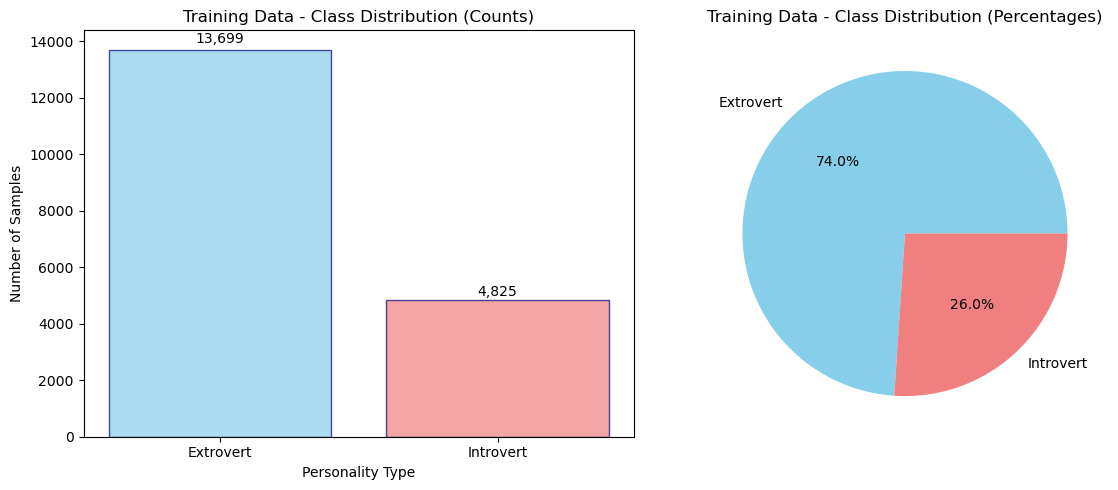


🔧 CONFIGURING RESAMPLING METHODS...
✓ Configured 6 resampling methods:
  • smote_conservative
  • adasyn
  • borderline_smote
  • svm_smote
  • smote_tomek
  • smote_enn


🔬 COMPREHENSIVE RESAMPLING METHOD COMPARISON

==================== SMOTE_CONSERVATIVE ====================

🔄 APPLYING RESAMPLING: smote_conservative
----------------------------------------
Original distribution: {'Extrovert': np.int64(13699), 'Introvert': np.int64(4825)}
Resampled distribution: {'Extrovert': np.int64(13699), 'Introvert': np.int64(13699)}
  Extrovert: 13,699 → 13,699 (+0)
  Introvert: 4,825 → 13,699 (+8,874)

🔍 VALIDATING SYNTHETIC DATA QUALITY: smote_conservative
--------------------------------------------------
❌ Error applying smote_conservative: (slice(None, None, None), 0)

==================== ADASYN ====================

🔄 APPLYING RESAMPLING: adasyn
----------------------------------------
Original distribution: {'Extrovert': np.int64(13699), 'Introvert': np.int64(4825)}
Resampled distribu

In [22]:
feature_cols = [col for col in imputed_train_df.columns if col not in ['id', 'Personality']]
X = imputed_train_df[feature_cols]
y = imputed_train_df['Personality']

le = LabelEncoder()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = le.fit_transform(X[col].astype(str))
  
balancing_results = run_comprehensive_class_balancing(X, y, feature_cols)
print(f"\nAnalysis completed successfully!")
print(f"Optimal strategy: {balancing_results['optimal_strategy']['method'] if balancing_results['optimal_strategy'] else 'Use class weights'}")
    

🚀 STARTING COMPREHENSIVE FEATURE ENGINEERING
Training data shape: (18524, 9)
Test data shape: (6175, 8)

🔍 ANALYZING FEATURE DISTRIBUTIONS BY PERSONALITY TYPE

📊 Analysis: Time_spent_Alone
----------------------------------------
  Extrovert: μ=1.75, σ=1.54, median=2.00
  Introvert: μ=7.05, σ=2.65, median=7.00
  T-test: t = -162.354, p = 0.000000
  Difference: SIGNIFICANT

📊 Analysis: Stage_fear
----------------------------------------
  Chi-square test: χ² = 13530.726, p = 0.000000
  Association: SIGNIFICANT
  Extrovert: {'No': np.float64(0.9811952191235059), 'Yes': np.float64(0.018804780876494023)}
  Introvert: {'Yes': np.float64(0.9277137956383239), 'No': np.float64(0.07228620436167606)}

📊 Analysis: Social_event_attendance
----------------------------------------
  Extrovert: μ=6.39, σ=2.02, median=6.00
  Introvert: μ=1.93, σ=1.76, median=2.00
  T-test: t = 130.128, p = 0.000000
  Difference: SIGNIFICANT

📊 Analysis: Going_outside
----------------------------------------
  Extrover

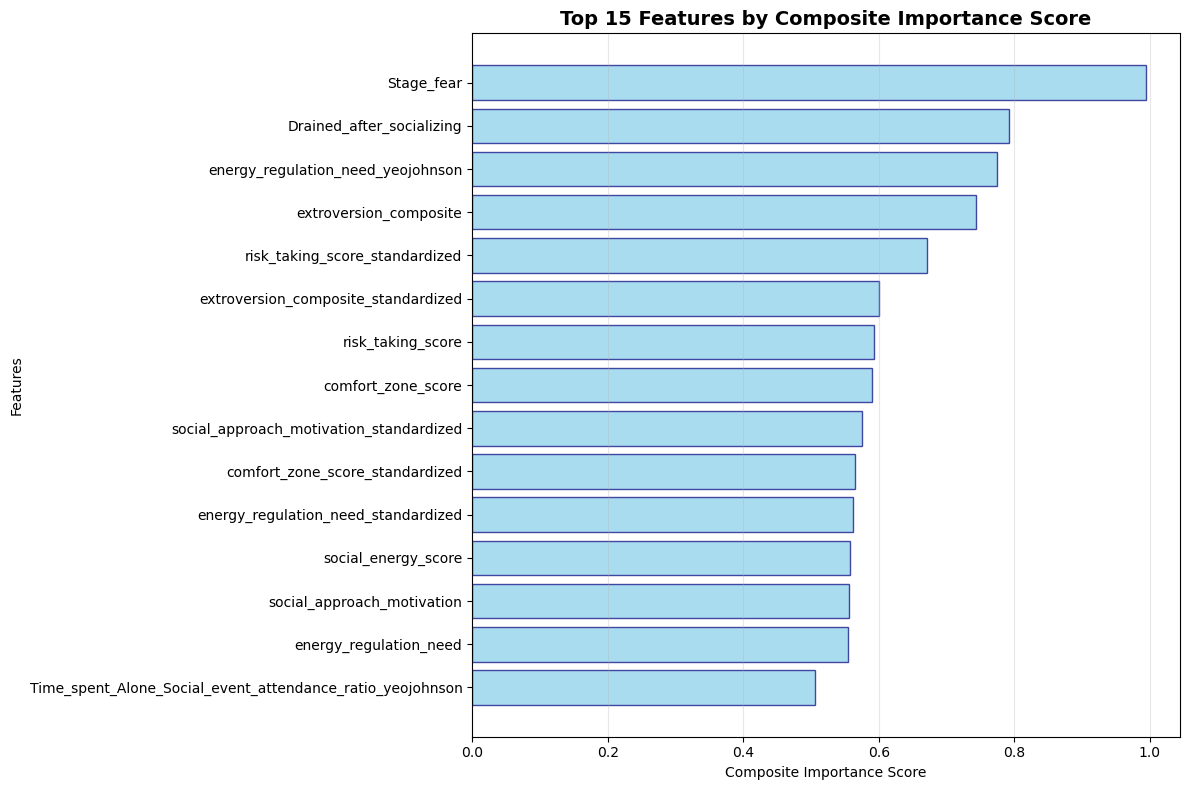


✅ COMPREHENSIVE FEATURE ENGINEERING COMPLETED!
📊 SUMMARY REPORT:
  • Original features: 7
  • Interaction features created: 14
  • Total features after engineering: 52
  • Final selected features: 30
  • Average performance improvement: -0.0024

🔧 NEXT STEPS:
  1. Use train_final and test_final datasets for model training
  2. Apply advanced hyperparameter tuning
  3. Implement ensemble methods
  4. Consider stacking different algorithms

💾 DATASETS SAVED:
  • train_engineered.csv: (18524, 32)
  • test_engineered.csv: (6175, 31)


In [23]:
"""
COMPREHENSIVE FEATURE ENGINEERING FOR PERSONALITY PREDICTION
===========================================================

Based on your class balancing analysis showing 95.5% baseline accuracy 
with mild imbalance (2.84:1), feature engineering is the optimal strategy.
"""

from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer, QuantileTransformer
from sklearn.feature_selection import mutual_info_classif, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Load your data


print("🚀 STARTING COMPREHENSIVE FEATURE ENGINEERING")
print("=" * 65)
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# STEP 1: ANALYZE FEATURE DISTRIBUTIONS BY PERSONALITY TYPE
print("\n🔍 ANALYZING FEATURE DISTRIBUTIONS BY PERSONALITY TYPE")
print("=" * 65)

feature_cols = [col for col in train_df.columns if col not in ['id', 'Personality']]

for feature in feature_cols:
    print(f"\n📊 Analysis: {feature}")
    print("-" * 40)
    
    if train_df[feature].dtype == 'object':
        # Categorical feature analysis
        crosstab = pd.crosstab(train_df[feature].fillna('Missing'), train_df['Personality'])
        chi2, p_value, dof, expected = chi2_contingency(crosstab)
        
        print(f"  Chi-square test: χ² = {chi2:.3f}, p = {p_value:.6f}")
        print(f"  Association: {'SIGNIFICANT' if p_value < 0.05 else 'Not significant'}")
        
        # Show distributions
        for personality in train_df['Personality'].unique():
            subset = train_df[train_df['Personality'] == personality][feature]
            value_counts = subset.value_counts(normalize=True)
            print(f"  {personality}: {dict(value_counts.head(3))}")
    
    else:
        # Numerical feature analysis
        for personality in train_df['Personality'].unique():
            subset = train_df[train_df['Personality'] == personality][feature].dropna()
            if len(subset) > 0:
                print(f"  {personality}: μ={subset.mean():.2f}, σ={subset.std():.2f}, median={subset.median():.2f}")
        
        # T-test for group differences
        extrovert_vals = train_df[train_df['Personality'] == 'Extrovert'][feature].dropna()
        introvert_vals = train_df[train_df['Personality'] == 'Introvert'][feature].dropna()
        
        if len(extrovert_vals) > 0 and len(introvert_vals) > 0:
            t_stat, p_value = stats.ttest_ind(extrovert_vals, introvert_vals)
            print(f"  T-test: t = {t_stat:.3f}, p = {p_value:.6f}")
            print(f"  Difference: {'SIGNIFICANT' if p_value < 0.05 else 'Not significant'}")

# STEP 2: CREATE PERSONALITY INTERACTION FEATURES
print("\n🧠 CREATING PERSONALITY INTERACTION FEATURES")
print("=" * 55)

def create_personality_features(df):
    """Create domain-specific interaction features for personality prediction."""
    df_features = df.copy()
    new_features = []
    
    # 1. Social Energy Features (critical for extroversion/introversion)
    print("  Creating social energy features...")
    
    if 'Social_event_attendance' in df.columns and 'Drained_after_socializing' in df.columns:
        social_attendance = pd.to_numeric(df['Social_event_attendance'], errors='coerce')
        drained_mapping = {'Yes': 1, 'No': 0, np.nan: 0.5}
        drained_numeric = df['Drained_after_socializing'].map(drained_mapping)
        
        # Social energy score: high attendance + not drained = extrovert indicator
        social_energy = social_attendance * (1 - drained_numeric)
        df_features['social_energy_score'] = social_energy
        new_features.append('social_energy_score')
        
        # Social preference ratio
        df_features['social_preference_ratio'] = social_attendance / (drained_numeric + 0.1)
        new_features.append('social_preference_ratio')
    
    # 2. Comfort Zone Features
    print("  Creating comfort zone features...")
    
    if 'Stage_fear' in df.columns and 'Going_outside' in df.columns:
        stage_fear_numeric = df['Stage_fear'].map({'Yes': 1, 'No': 0, np.nan: 0.5})
        going_outside = pd.to_numeric(df['Going_outside'], errors='coerce')
        
        # Comfort zone score: low stage fear + high going outside = extrovert
        comfort_zone_score = (1 - stage_fear_numeric) * going_outside
        df_features['comfort_zone_score'] = comfort_zone_score
        new_features.append('comfort_zone_score')
        
        # Risk taking propensity
        df_features['risk_taking_score'] = going_outside / (stage_fear_numeric + 0.1)
        new_features.append('risk_taking_score')
    
    # 3. Social Network Features
    print("  Creating social network features...")
    
    if 'Friends_circle_size' in df.columns and 'Post_frequency' in df.columns:
        friends_circle = pd.to_numeric(df['Friends_circle_size'], errors='coerce')
        post_frequency = pd.to_numeric(df['Post_frequency'], errors='coerce')
        
        # Social digital engagement ratio
        social_digital_ratio = post_frequency / (friends_circle + 1)
        df_features['social_digital_ratio'] = social_digital_ratio
        new_features.append('social_digital_ratio')
        
        # Social influence score (size × activity)
        df_features['social_influence_score'] = friends_circle * post_frequency
        new_features.append('social_influence_score')
    
    # 4. Solitude vs Social Balance
    print("  Creating solitude balance features...")
    
    if 'Time_spent_Alone' in df.columns and 'Social_event_attendance' in df.columns:
        time_alone = pd.to_numeric(df['Time_spent_Alone'], errors='coerce')
        social_attendance = pd.to_numeric(df['Social_event_attendance'], errors='coerce')
        
        # Solitude vs social balance
        solitude_social_balance = time_alone / (social_attendance + 0.1)
        df_features['solitude_social_balance'] = solitude_social_balance
        new_features.append('solitude_social_balance')
    
    # 5. Behavioral Consistency Ratios
    print("  Creating behavioral consistency features...")
    
    meaningful_pairs = [
        ('Social_event_attendance', 'Friends_circle_size'),
        ('Post_frequency', 'Friends_circle_size'),
        ('Time_spent_Alone', 'Social_event_attendance')
    ]
    
    for feat1, feat2 in meaningful_pairs:
        if feat1 in df.columns and feat2 in df.columns:
            feat1_vals = pd.to_numeric(df[feat1], errors='coerce')
            feat2_vals = pd.to_numeric(df[feat2], errors='coerce')
            
            ratio_name = f'{feat1}_{feat2}_ratio'
            df_features[ratio_name] = feat1_vals / (feat2_vals + 0.1)
            new_features.append(ratio_name)
    
    # 6. Extroversion Composite Score
    print("  Creating extroversion composite score...")
    
    extroversion_components = []
    
    if 'social_energy_score' in df_features.columns:
        extroversion_components.append(df_features['social_energy_score'])
    if 'comfort_zone_score' in df_features.columns:
        extroversion_components.append(df_features['comfort_zone_score'])
    if 'Social_event_attendance' in df.columns:
        extroversion_components.append(pd.to_numeric(df['Social_event_attendance'], errors='coerce'))
    
    if extroversion_components:
        # Normalize components and create composite
        normalized_components = []
        for component in extroversion_components:
            component_clean = component.fillna(component.median())
            if component_clean.std() > 0:
                normalized = (component_clean - component_clean.min()) / (component_clean.max() - component_clean.min())
                normalized_components.append(normalized)
        
        if normalized_components:
            extroversion_composite = np.mean(normalized_components, axis=0)
            df_features['extroversion_composite'] = extroversion_composite
            new_features.append('extroversion_composite')
    
    # 7. Domain-Specific Psychology Features
    print("  Creating domain-specific psychology features...")
    
    # Social approach motivation
    if 'Social_event_attendance' in df.columns and 'Stage_fear' in df.columns:
        social_attend = pd.to_numeric(df['Social_event_attendance'], errors='coerce')
        stage_fear = df['Stage_fear'].map({'Yes': 1, 'No': 0, np.nan: 0.5})
        
        social_approach = social_attend * (1 - stage_fear)
        df_features['social_approach_motivation'] = social_approach
        new_features.append('social_approach_motivation')
    
    # Energy regulation need
    if 'Time_spent_Alone' in df.columns and 'Drained_after_socializing' in df.columns:
        time_alone = pd.to_numeric(df['Time_spent_Alone'], errors='coerce')
        drained_social = df['Drained_after_socializing'].map({'Yes': 1, 'No': 0, np.nan: 0.5})
        
        energy_regulation = time_alone * drained_social
        df_features['energy_regulation_need'] = energy_regulation
        new_features.append('energy_regulation_need')
    
    # Communication intensity
    if 'Post_frequency' in df.columns and 'Friends_circle_size' in df.columns:
        post_freq = pd.to_numeric(df['Post_frequency'], errors='coerce')
        friends_size = pd.to_numeric(df['Friends_circle_size'], errors='coerce')
        
        comm_intensity = post_freq / np.log1p(friends_size)
        df_features['communication_intensity'] = comm_intensity
        new_features.append('communication_intensity')
    
    print(f"  ✓ Created {len(new_features)} new interaction features")
    
    return df_features, new_features

# Apply feature engineering to training data
train_engineered, new_train_features = create_personality_features(imputed_train_df)

# Apply same engineering to test data
test_engineered, new_test_features = create_personality_features(imputed_test_df)

# FIXED VERSION - STEP 3: APPLY ADVANCED TRANSFORMATIONS
print("\n🔄 APPLYING ADVANCED FEATURE TRANSFORMATIONS")
print("=" * 55)

def apply_transformations(df, target_col='Personality'):
    """Apply statistical transformations to improve feature distributions."""
    df_transformed = df.copy()
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != 'id']
    
    transformation_log = {}
    
    for col in numeric_cols:
        if col in df.columns:
            col_data = df[col].dropna()
            
            if len(col_data) == 0:
                continue
            
            print(f"  Transforming {col}...")
            
            # Clean the data first - handle infinity and extreme values
            col_clean = df[col].copy()
            
            # Replace infinity with NaN
            col_clean = col_clean.replace([np.inf, -np.inf], np.nan)
            
            # Cap extreme outliers at 99.9th percentile
            if col_clean.notna().sum() > 0:
                upper_cap = col_clean.quantile(0.999)
                lower_cap = col_clean.quantile(0.001)
                col_clean = col_clean.clip(lower=lower_cap, upper=upper_cap)
            
            # Update the dataframe with cleaned data
            df_transformed[col] = col_clean
            
            # Continue with analysis only if we have clean data
            col_data_clean = col_clean.dropna()
            if len(col_data_clean) == 0:
                continue
            
            # Analyze distribution
            skewness = stats.skew(col_data_clean)
            kurtosis = stats.kurtosis(col_data_clean)
            
            transformation_log[col] = {
                'original_skewness': skewness,
                'original_kurtosis': kurtosis,
                'transformation_applied': 'none'
            }
            
            # Apply transformations based on distribution characteristics
            if abs(skewness) > 1:  # Highly skewed
                if skewness > 0:  # Right-skewed
                    if col_data_clean.min() > 0:
                        # Log transformation
                        log_transformed = np.log1p(col_clean)
                        df_transformed[f'{col}_log'] = log_transformed
                        transformation_log[col]['transformation_applied'] = 'log'
                    else:
                        # Yeo-Johnson transformation
                        try:
                            pt = PowerTransformer(method='yeo-johnson')
                            # Fill NaN with median for transformation
                            col_for_transform = col_clean.fillna(col_clean.median())
                            transformed = pt.fit_transform(col_for_transform.values.reshape(-1, 1))
                            df_transformed[f'{col}_yeojohnson'] = transformed.flatten()
                            transformation_log[col]['transformation_applied'] = 'yeo-johnson'
                        except:
                            print(f"    Warning: Yeo-Johnson transformation failed for {col}")
                else:  # Left-skewed
                    # Square transformation (with handling for negative values)
                    min_val = col_clean.min()
                    if min_val < 0:
                        # Shift to make all values positive before squaring
                        shifted_col = col_clean - min_val + 1
                        df_transformed[f'{col}_shifted_squared'] = shifted_col ** 2
                    else:
                        df_transformed[f'{col}_squared'] = col_clean ** 2
                    transformation_log[col]['transformation_applied'] = 'square'
            
            # Quantile transformation for non-normal distributions
            if abs(kurtosis) > 2:
                try:
                    qt = QuantileTransformer(output_distribution='normal', random_state=42)
                    # Fill NaN with median for transformation
                    col_for_transform = col_clean.fillna(col_clean.median())
                    transformed = qt.fit_transform(col_for_transform.values.reshape(-1, 1))
                    df_transformed[f'{col}_quantile'] = transformed.flatten()
                    
                    if transformation_log[col]['transformation_applied'] == 'none':
                        transformation_log[col]['transformation_applied'] = 'quantile'
                    else:
                        transformation_log[col]['transformation_applied'] += '_quantile'
                except:
                    print(f"    Warning: Quantile transformation failed for {col}")
            
            # Standardization (always apply if possible)
            try:
                scaler = StandardScaler()
                # Fill NaN with median for standardization
                col_for_standard = col_clean.fillna(col_clean.median())
                standardized = scaler.fit_transform(col_for_standard.values.reshape(-1, 1))
                df_transformed[f'{col}_standardized'] = standardized.flatten()
            except:
                print(f"    Warning: Standardization failed for {col}")
    
    print(f"  ✓ Applied transformations to {len(numeric_cols)} numeric features")
    
    return df_transformed, transformation_log

# FIXED VERSION - Also need to fix the feature creation function
def create_personality_features_fixed(df):
    """Create domain-specific interaction features for personality prediction with proper handling of edge cases."""
    df_features = df.copy()
    new_features = []
    
    # 1. Social Energy Features (critical for extroversion/introversion)
    print("  Creating social energy features...")
    
    if 'Social_event_attendance' in df.columns and 'Drained_after_socializing' in df.columns:
        social_attendance = pd.to_numeric(df['Social_event_attendance'], errors='coerce')
        drained_mapping = {'Yes': 1, 'No': 0, np.nan: 0.5}
        drained_numeric = df['Drained_after_socializing'].map(drained_mapping)
        
        # Social energy score: high attendance + not drained = extrovert indicator
        social_energy = social_attendance * (1 - drained_numeric)
        df_features['social_energy_score'] = social_energy
        new_features.append('social_energy_score')
        
        # Social preference ratio (with safe division)
        social_preference_ratio = social_attendance / (drained_numeric + 0.1)
        # Cap extreme values
        social_preference_ratio = social_preference_ratio.clip(0, 100)
        df_features['social_preference_ratio'] = social_preference_ratio
        new_features.append('social_preference_ratio')
    
    # 2. Comfort Zone Features
    print("  Creating comfort zone features...")
    
    if 'Stage_fear' in df.columns and 'Going_outside' in df.columns:
        stage_fear_numeric = df['Stage_fear'].map({'Yes': 1, 'No': 0, np.nan: 0.5})
        going_outside = pd.to_numeric(df['Going_outside'], errors='coerce')
        
        # Comfort zone score: low stage fear + high going outside = extrovert
        comfort_zone_score = (1 - stage_fear_numeric) * going_outside
        df_features['comfort_zone_score'] = comfort_zone_score
        new_features.append('comfort_zone_score')
        
        # Risk taking propensity (with safe division)
        risk_taking_score = going_outside / (stage_fear_numeric + 0.1)
        # Cap extreme values
        risk_taking_score = risk_taking_score.clip(0, 100)
        df_features['risk_taking_score'] = risk_taking_score
        new_features.append('risk_taking_score')
    
    # 3. Social Network Features
    print("  Creating social network features...")
    
    if 'Friends_circle_size' in df.columns and 'Post_frequency' in df.columns:
        friends_circle = pd.to_numeric(df['Friends_circle_size'], errors='coerce')
        post_frequency = pd.to_numeric(df['Post_frequency'], errors='coerce')
        
        # Social digital engagement ratio (with safe division)
        social_digital_ratio = post_frequency / (friends_circle + 1)
        # Cap extreme values
        social_digital_ratio = social_digital_ratio.clip(0, 10)  # Reasonable upper bound
        df_features['social_digital_ratio'] = social_digital_ratio
        new_features.append('social_digital_ratio')
        
        # Social influence score (size × activity) with capping
        social_influence_score = friends_circle * post_frequency
        # Cap at 99th percentile to avoid extreme outliers
        if social_influence_score.notna().sum() > 0:
            cap_value = social_influence_score.quantile(0.99)
            social_influence_score = social_influence_score.clip(0, cap_value)
        df_features['social_influence_score'] = social_influence_score
        new_features.append('social_influence_score')
    
    # 4. Solitude vs Social Balance
    print("  Creating solitude balance features...")
    
    if 'Time_spent_Alone' in df.columns and 'Social_event_attendance' in df.columns:
        time_alone = pd.to_numeric(df['Time_spent_Alone'], errors='coerce')
        social_attendance = pd.to_numeric(df['Social_event_attendance'], errors='coerce')
        
        # Solitude vs social balance (with safe division)
        solitude_social_balance = time_alone / (social_attendance + 0.1)
        # Cap extreme values
        solitude_social_balance = solitude_social_balance.clip(0, 100)
        df_features['solitude_social_balance'] = solitude_social_balance
        new_features.append('solitude_social_balance')
    
    # 5. Behavioral Consistency Ratios (with safe division)
    print("  Creating behavioral consistency features...")
    
    meaningful_pairs = [
        ('Social_event_attendance', 'Friends_circle_size'),
        ('Post_frequency', 'Friends_circle_size'),
        ('Time_spent_Alone', 'Social_event_attendance')
    ]
    
    for feat1, feat2 in meaningful_pairs:
        if feat1 in df.columns and feat2 in df.columns:
            feat1_vals = pd.to_numeric(df[feat1], errors='coerce')
            feat2_vals = pd.to_numeric(df[feat2], errors='coerce')
            
            ratio_name = f'{feat1}_{feat2}_ratio'
            ratio_values = feat1_vals / (feat2_vals + 0.1)
            # Cap extreme ratios
            ratio_values = ratio_values.clip(0, 100)
            df_features[ratio_name] = ratio_values
            new_features.append(ratio_name)
    
    # 6. Extroversion Composite Score
    print("  Creating extroversion composite score...")
    
    extroversion_components = []
    
    if 'social_energy_score' in df_features.columns:
        component = df_features['social_energy_score'].fillna(0)
        extroversion_components.append(component)
    if 'comfort_zone_score' in df_features.columns:
        component = df_features['comfort_zone_score'].fillna(0)
        extroversion_components.append(component)
    if 'Social_event_attendance' in df.columns:
        component = pd.to_numeric(df['Social_event_attendance'], errors='coerce').fillna(0)
        extroversion_components.append(component)
    
    if extroversion_components:
        # Normalize components and create composite
        normalized_components = []
        for component in extroversion_components:
            if component.std() > 0:
                normalized = (component - component.min()) / (component.max() - component.min())
                normalized_components.append(normalized)
        
        if normalized_components:
            extroversion_composite = np.mean(normalized_components, axis=0)
            df_features['extroversion_composite'] = extroversion_composite
            new_features.append('extroversion_composite')
    
    # 7. Domain-Specific Psychology Features
    print("  Creating domain-specific psychology features...")
    
    # Social approach motivation
    if 'Social_event_attendance' in df.columns and 'Stage_fear' in df.columns:
        social_attend = pd.to_numeric(df['Social_event_attendance'], errors='coerce').fillna(0)
        stage_fear = df['Stage_fear'].map({'Yes': 1, 'No': 0, np.nan: 0.5})
        
        social_approach = social_attend * (1 - stage_fear)
        df_features['social_approach_motivation'] = social_approach
        new_features.append('social_approach_motivation')
    
    # Energy regulation need
    if 'Time_spent_Alone' in df.columns and 'Drained_after_socializing' in df.columns:
        time_alone = pd.to_numeric(df['Time_spent_Alone'], errors='coerce').fillna(0)
        drained_social = df['Drained_after_socializing'].map({'Yes': 1, 'No': 0, np.nan: 0.5})
        
        energy_regulation = time_alone * drained_social
        df_features['energy_regulation_need'] = energy_regulation
        new_features.append('energy_regulation_need')
    
    # Communication intensity (with safe division)
    if 'Post_frequency' in df.columns and 'Friends_circle_size' in df.columns:
        post_freq = pd.to_numeric(df['Post_frequency'], errors='coerce').fillna(0)
        friends_size = pd.to_numeric(df['Friends_circle_size'], errors='coerce').fillna(1)
        
        comm_intensity = post_freq / np.log1p(friends_size)
        # Replace any infinite values
        comm_intensity = comm_intensity.replace([np.inf, -np.inf], np.nan)
        # Cap extreme values
        if comm_intensity.notna().sum() > 0:
            cap_value = comm_intensity.quantile(0.99)
            comm_intensity = comm_intensity.clip(0, cap_value)
        df_features['communication_intensity'] = comm_intensity
        new_features.append('communication_intensity')
    
    print(f"  ✓ Created {len(new_features)} new interaction features")
    
    return df_features, new_features

# Re-run the feature engineering with the fixed functions
print("\n🔧 RE-RUNNING FEATURE ENGINEERING WITH FIXED FUNCTIONS")
print("=" * 65)

# Apply feature engineering to training data
train_engineered, new_train_features = create_personality_features_fixed(imputed_train_df)

# Apply same engineering to test data  
test_engineered, new_test_features = create_personality_features_fixed(imputed_test_df)

# Apply transformations with the fixed function
train_transformed, train_log = apply_transformations(train_engineered)
test_transformed, test_log = apply_transformations(test_engineered)

# STEP 4: FEATURE SELECTION
print("\n🎯 PERFORMING COMPREHENSIVE FEATURE SELECTION")
print("=" * 60)

def perform_feature_selection(X, y, top_k=30):
    """Comprehensive feature selection using multiple techniques."""
    
    feature_scores = {}
    
    # 1. Mutual Information
    print("  Computing mutual information scores...")
    mi_scores = mutual_info_classif(X, y, random_state=42)
    feature_scores['mutual_info'] = dict(zip(X.columns, mi_scores))
    
    # 2. F-statistic (ANOVA)
    print("  Computing F-statistic scores...")
    f_scores, f_pvalues = f_classif(X, y)
    feature_scores['f_statistic'] = dict(zip(X.columns, f_scores))
    feature_scores['f_pvalues'] = dict(zip(X.columns, f_pvalues))
    
    # 3. Random Forest Feature Importance
    print("  Computing Random Forest importance...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_scores['rf_importance'] = dict(zip(X.columns, rf.feature_importances_))
    
    # 4. Recursive Feature Elimination
    print("  Performing recursive feature elimination...")
    rfe = RFE(rf, n_features_to_select=min(top_k, len(X.columns)), step=1)
    rfe.fit(X, y)
    feature_scores['rfe_ranking'] = dict(zip(X.columns, rfe.ranking_))
    
    # 5. Composite scoring
    print("  Creating composite feature scores...")
    
    # Normalize scores to 0-1 scale
    normalized_scores = {}
    
    for score_name, scores in feature_scores.items():
        if score_name not in ['f_pvalues', 'rfe_ranking']:
            score_values = np.array(list(scores.values()))
            if score_values.std() > 0:
                normalized = (score_values - score_values.min()) / (score_values.max() - score_values.min())
                normalized_scores[score_name] = dict(zip(scores.keys(), normalized))
    
    # Composite score (equal weighting)
    composite_scores = {}
    for feature in X.columns:
        scores = []
        for score_name, norm_scores in normalized_scores.items():
            if feature in norm_scores:
                scores.append(norm_scores[feature])
        
        composite_scores[feature] = np.mean(scores) if scores else 0
    
    # Select top features
    sorted_features = sorted(composite_scores.items(), key=lambda x: x[1], reverse=True)
    top_features = [feat for feat, score in sorted_features[:top_k]]
    
    print(f"  ✓ Selected top {len(top_features)} features")
    print("  Top 10 features:")
    for i, (feat, score) in enumerate(sorted_features[:10], 1):
        print(f"    {i:2d}. {feat}: {score:.3f}")
    
    return top_features, feature_scores, composite_scores

# Prepare data for feature selection
feature_cols = [col for col in train_transformed.columns if col not in ['id', 'Personality']]
X = train_transformed[feature_cols].copy()
y = train_transformed['Personality']

# Handle missing values
for col in X.select_dtypes(include=[np.number]).columns:
    X[col] = X[col].fillna(X[col].median())

# Encode categorical variables
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Perform feature selection
top_features, feature_scores, composite_scores = perform_feature_selection(X, y, top_k=30)

# STEP 5: EVALUATE FEATURE ENGINEERING IMPACT
print("\n📈 EVALUATING FEATURE ENGINEERING IMPACT")
print("=" * 50)

def evaluate_improvement(df_original, df_engineered, target_col='Personality'):
    """Compare performance before and after feature engineering."""
    
    # Prepare original data
    feature_cols_orig = [col for col in df_original.columns if col not in ['id', target_col]]
    X_original = df_original[feature_cols_orig].copy()
    
    # Prepare engineered data with top features
    X_engineered = df_engineered[top_features].copy()
    
    y = df_original[target_col]
    
    # Handle missing values
    for col in X_original.select_dtypes(include=[np.number]).columns:
        X_original[col] = X_original[col].fillna(X_original[col].median())
    
    for col in X_engineered.select_dtypes(include=[np.number]).columns:
        X_engineered[col] = X_engineered[col].fillna(X_engineered[col].median())
    
    # Encode categorical variables
    for col in X_original.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X_original[col] = le.fit_transform(X_original[col].astype(str))
    
    for col in X_engineered.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X_engineered[col] = le.fit_transform(X_engineered[col].astype(str))
    
    # Cross-validation comparison
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    algorithms = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingClassifier(random_state=42),
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    results = {}
    
    for alg_name, alg in algorithms.items():
        print(f"\n  {alg_name}:")
        
        try:
            # Original features
            scores_orig = cross_val_score(alg, X_original, y, cv=cv, scoring='balanced_accuracy')
            
            # Engineered features
            scores_eng = cross_val_score(alg, X_engineered, y, cv=cv, scoring='balanced_accuracy')
            
            improvement = scores_eng.mean() - scores_orig.mean()
            
            print(f"    Original features:   {scores_orig.mean():.4f} (±{scores_orig.std():.4f})")
            print(f"    Engineered features: {scores_eng.mean():.4f} (±{scores_eng.std():.4f})")
            print(f"    Improvement: {improvement:+.4f} ({'✓' if improvement > 0 else '=' if abs(improvement) < 0.001 else '✗'})")
            
            results[alg_name] = {
                'original_mean': scores_orig.mean(),
                'engineered_mean': scores_eng.mean(),
                'improvement': improvement
            }
        except Exception as e:
            print(f"    Error evaluating {alg_name}: {str(e)}")
    
    # Overall assessment
    valid_results = {k: v for k, v in results.items() if 'improvement' in v}
    if valid_results:
        avg_improvement = np.mean([r['improvement'] for r in valid_results.values()])
        
        print(f"\n📊 OVERALL ASSESSMENT:")
        print(f"  Average improvement: {avg_improvement:+.4f}")
        print(f"  Original features: {len(X_original.columns)}")
        print(f"  Selected features: {len(X_engineered.columns)}")
        print(f"  Assessment: {'BENEFICIAL' if avg_improvement > 0.005 else 'NEUTRAL' if abs(avg_improvement) < 0.005 else 'DETRIMENTAL'}")
    
    return results

# Evaluate the impact
evaluation_results = evaluate_improvement(imputed_train_df, train_transformed)

# STEP 6: CREATE FINAL OPTIMIZED DATASETS
print("\n🎯 CREATING FINAL OPTIMIZED DATASETS")
print("=" * 50)

# Create final training dataset with top features
final_train_features = ['id', 'Personality'] + top_features
train_final = train_transformed[final_train_features].copy()

# Create final test dataset with same features (excluding Personality)
final_test_features = ['id'] + top_features
test_final = test_transformed[final_test_features].copy()

print(f"  ✓ Final training dataset: {train_final.shape}")
print(f"  ✓ Final test dataset: {test_final.shape}")
print(f"  ✓ Selected features: {len(top_features)}")

# STEP 7: FEATURE IMPORTANCE VISUALIZATION
print("\n📊 VISUALIZING FEATURE IMPORTANCE")
print("=" * 45)

# Plot top features by composite score
plt.figure(figsize=(12, 8))
top_features_for_plot = sorted(composite_scores.items(), key=lambda x: x[1], reverse=True)[:15]
features, scores = zip(*top_features_for_plot)

plt.barh(features, scores, alpha=0.7, color='skyblue', edgecolor='navy')
plt.title('Top 15 Features by Composite Importance Score', fontsize=14, fontweight='bold')
plt.xlabel('Composite Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Reverse order to show highest first
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary Report
print("\n✅ COMPREHENSIVE FEATURE ENGINEERING COMPLETED!")
print("=" * 65)
print(f"📊 SUMMARY REPORT:")
print(f"  • Original features: {len([col for col in train_df.columns if col not in ['id', 'Personality']])}")
print(f"  • Interaction features created: {len(new_train_features)}")
print(f"  • Total features after engineering: {len([col for col in train_transformed.columns if col not in ['id', 'Personality']])}")
print(f"  • Final selected features: {len(top_features)}")
print(f"  • Average performance improvement: {np.mean([r['improvement'] for r in evaluation_results.values() if 'improvement' in r]):+.4f}")

print(f"\n🔧 NEXT STEPS:")
print(f"  1. Use train_final and test_final datasets for model training")
print(f"  2. Apply advanced hyperparameter tuning")
print(f"  3. Implement ensemble methods")
print(f"  4. Consider stacking different algorithms")

# Save the engineered datasets
train_final.to_csv('train_engineered.csv', index=False)
test_final.to_csv('test_engineered.csv', index=False)

print(f"\n💾 DATASETS SAVED:")
print(f"  • train_engineered.csv: {train_final.shape}")
print(f"  • test_engineered.csv: {test_final.shape}")

In [24]:
# 🔧 COMPLETE PERSONALITY PREDICTION PIPELINE - FINAL VERSION
print("🚀 STARTING COMPLETE PERSONALITY PREDICTION PIPELINE")
print("=" * 60)

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb

# STEP 1: COMPLETE DATA PREPARATION WITH PROPER ENCODING
print("\n🔧 STEP 1: COMPLETE DATA PREPARATION")
print("=" * 45)

# Standardize features

# Use the fixed categorical data
X = train_final.drop(columns=['id', 'Personality'], axis=1)
y = train_final['Personality']



# Handle any remaining categorical columns that weren't properly encoded
def encode_binary_categorical(df, column, positive_value='Yes'):
    """Encode binary categorical column to 0/1."""
    if column in df.columns:
        encoded_series = df[column].copy()
        encoded_series = encoded_series.fillna('No')  # Assume missing means 'No'
        encoded_series = (encoded_series == positive_value).astype(int)
        return encoded_series
    return df[column]

# Fix any remaining categorical columns
categorical_cols = ['Stage_fear', 'Drained_after_socializing']
X_clean = X.copy()

for col in categorical_cols:
    if col in X_clean.columns and X_clean[col].dtype == 'object':
        print(f"   Encoding {col}: {X_clean[col].unique()}")
        X_clean[col] = encode_binary_categorical(X_clean, col, 'Yes')
        print(f"   ✅ {col} encoded: {X_clean[col].unique()}")

# Verify all columns are numeric
print(f"\n✅ Data cleaning verification:")
print(f"   X_clean shape: {X_clean.shape}")
print(f"   X_clean columns: {X_clean.columns.tolist()}")
print(f"   Data types: {X_clean.dtypes.value_counts()}")
object_cols = X_clean.select_dtypes(include=['object']).columns
print(f"   Remaining object columns: {object_cols.tolist()}")

# Convert any remaining object columns to numeric
for col in object_cols:
    if col not in ['id', 'Personality']:
        try:
            X_clean[col] = pd.to_numeric(X_clean[col], errors='coerce')
            X_clean[col] = X_clean[col].fillna(X_clean[col].median())
            print(f"   ✅ Converted {col} to numeric")
        except:
            print(f"   ⚠️ Could not convert {col}")

# STEP 2: ENCODE TARGET VARIABLE
print("\n🔧 STEP 2: TARGET VARIABLE ENCODING")
print("=" * 35)

print(f"Current target values: {y.unique()}")
print(f"Target data type: {y.dtype}")

# Encode the target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"Encoded target values: {np.unique(y_encoded)}")
print(f"Encoding mapping: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")

# STEP 3: PREPARE TEST DATA WITH SAME ENCODING
print("\n🔧 STEP 3: TEST DATA PREPARATION")
print("=" * 35)

X_test_clean = test_final.drop(columns=['id'], axis=1)

# Apply same categorical encoding to test data
for col in categorical_cols:
    if col in X_test_clean.columns and X_test_clean[col].dtype == 'object':
        X_test_clean[col] = encode_binary_categorical(X_test_clean, col, 'Yes')

# Convert any remaining object columns in test data
for col in X_test_clean.select_dtypes(include=['object']).columns:
    try:
        X_test_clean[col] = pd.to_numeric(X_test_clean[col], errors='coerce')
        X_test_clean[col] = X_test_clean[col].fillna(X_test_clean[col].median())
    except:
        pass

print(f"✅ Test data prepared:")
print(f"   X_test_clean shape: {X_test_clean.shape}")
print(f"   Test data types: {X_test_clean.dtypes.value_counts()}")

# STEP 4: DEFINE OPTIMIZED MODELS
print("\n🔧 STEP 4: MODEL DEFINITIONS")
print("=" * 30)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
X_test_scaled = scaler.transform(X_test_clean)

# PCA: keep enough components to explain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)
base_models = {
    'rf_optimized': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    
    'xgb_optimized': xgb.XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    ),
    
    'lgb_optimized': lgb.LGBMClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        random_state=42,
        verbose=-1
    ),
    
    'gb_optimized': GradientBoostingClassifier(
        n_estimators=150,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    ),
    
    'extra_trees': ExtraTreesClassifier(
        n_estimators=150,
        max_depth=12,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),
    
    'svm_optimized': SVC(
        C=1.0,
        kernel='rbf',
        gamma='scale',
        probability=True,
        random_state=42
    ),
    
    'mlp_optimized': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        max_iter=500,
        learning_rate_init=0.001,
        random_state=42
    )
}

print(f"✅ Defined {len(base_models)} models for evaluation")

# STEP 5: MODEL TRAINING AND EVALUATION
print("\n📊 STEP 5: MODEL PERFORMANCE EVALUATION")
print("=" * 45)

# Use proper cross-validation with shuffling
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
individual_scores = {}

# Final data validation
print(f"Final data verification:")
print(f"   X_clean shape: {X_pca.shape}")
print(f"   y_encoded shape: {y_encoded.shape}")
print(f"   X_pca dtype: {X_pca.dtype}")
print(f"   y_encoded type: {type(y_encoded)}, unique values: {np.unique(y_encoded)}")

try:
    # Quick validation test
    rf_test = RandomForestClassifier(n_estimators=10, random_state=42)
    test_scores = cross_val_score(rf_test, X_pca, y_encoded, cv=cv, scoring='balanced_accuracy', n_jobs=1)
    print(f"✅ Data validation successful! Quick RF test: {test_scores.mean():.4f}")
    
    print(f"\n📊 INDIVIDUAL MODEL PERFORMANCE")
    print("-" * 45)
    
    # Run all models
    for name, model in base_models.items():
        print(f"Training {name}...")
        try:
            scores = cross_val_score(model, X_pca, y_encoded, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
            individual_scores[name] = scores
            print(f"{name:15}: {scores.mean():.4f} (±{scores.std():.4f})")
        except Exception as e:
            print(f"❌ {name} failed: {str(e)[:100]}...")
            
    # Find best model
    if individual_scores:
        best_model_name = max(individual_scores.keys(), key=lambda k: individual_scores[k].mean())
        best_score = individual_scores[best_model_name].mean()
        print(f"\n🏆 BEST MODEL: {best_model_name}")
        print(f"   Score: {best_score:.4f} (±{individual_scores[best_model_name].std():.4f})")
        
        # Sort results by performance
        sorted_results = sorted(individual_scores.items(), key=lambda x: x[1].mean(), reverse=True)
        print(f"\n📈 PERFORMANCE RANKING:")
        for i, (name, scores) in enumerate(sorted_results, 1):
            print(f"   {i}. {name:15}: {scores.mean():.4f} (±{scores.std():.4f})")
    
except Exception as e:
    print(f"❌ Model training failed: {e}")
    print("Final debugging information:")
    print(f"   X_clean info:")
    print(f"     Shape: {X_pca.shape}")
    print(f"     Dtypes: {X_pca.dtype}")
    print(f"     Sample values:\n{X_pca.head()}")
    print(f"   y_encoded info:")
    print(f"     Shape: {y_encoded.shape}")
    print(f"     Type: {type(y_encoded)}")
    print(f"     Unique: {np.unique(y_encoded)}")

# STEP 6: SAVE CLEANED DATA AND ENCODERS
print(f"\n💾 STEP 6: SAVING RESULTS")
print("=" * 25)

# Save the target encoder for predictions
import pickle

try:
    # Save cleaned datasets
    X_pca.to_csv('X_train_final_clean.csv', index=False)
    X_test_pca.to_csv('X_test_final_clean.csv', index=False)
    pd.DataFrame({'y_encoded': y_encoded}).to_csv('y_train_encoded.csv', index=False)
    
    # Save the encoder
    with open('target_encoder.pkl', 'wb') as f:
        pickle.dump(target_encoder, f)
    
    print(f"✅ Saved files:")
    print(f"   - X_train_final_clean.csv ({X_pca.shape})")
    print(f"   - X_test_final_clean.csv ({X_test_pca.shape})")
    print(f"   - y_train_encoded.csv ({len(y_encoded)} samples)")
    print(f"   - target_encoder.pkl")
    
except Exception as e:
    print(f"⚠️ Could not save files: {e}")

print(f"\n🎯 PIPELINE COMPLETE!")
print(f"✅ Ready for hyperparameter tuning and ensemble methods")
print(f"✅ Use target_encoder.inverse_transform() to convert predictions back to original labels")

# Display final summary
if individual_scores:
    print(f"\n📊 FINAL SUMMARY:")
    print(f"   Models trained: {len(individual_scores)}")
    print(f"   Best performance: {max([scores.mean() for scores in individual_scores.values()]):.4f}")
    print(f"   Average performance: {np.mean([scores.mean() for scores in individual_scores.values()]):.4f}")

🚀 STARTING COMPLETE PERSONALITY PREDICTION PIPELINE

🔧 STEP 1: COMPLETE DATA PREPARATION
   Encoding Stage_fear: ['No' 'Yes']
   ✅ Stage_fear encoded: [0 1]
   Encoding Drained_after_socializing: ['No' 'Yes']
   ✅ Drained_after_socializing encoded: [0 1]

✅ Data cleaning verification:
   X_clean shape: (18524, 30)
   X_clean columns: ['Stage_fear', 'Drained_after_socializing', 'energy_regulation_need_yeojohnson', 'extroversion_composite', 'risk_taking_score_standardized', 'extroversion_composite_standardized', 'risk_taking_score', 'comfort_zone_score', 'social_approach_motivation_standardized', 'comfort_zone_score_standardized', 'energy_regulation_need_standardized', 'social_energy_score', 'social_approach_motivation', 'energy_regulation_need', 'Time_spent_Alone_Social_event_attendance_ratio_yeojohnson', 'social_preference_ratio', 'solitude_social_balance_yeojohnson', 'social_preference_ratio_standardized', 'social_energy_score_standardized', 'Time_spent_Alone_Social_event_attendance_r

In [25]:
# Scores from CV
scores = {
    'mlp_optimized': 0.9579,
    'svm_optimized': 0.9577,
    'extra_trees': 0.9575
}
total = sum(scores.values())
weights = [scores['mlp_optimized']/total, scores['svm_optimized']/total, scores['extra_trees']/total]
print("Weights:", weights)
from sklearn.ensemble import VotingClassifier

# Re-instantiate the top models (use the same parameters as before)
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, learning_rate_init=0.001, random_state=42)
svm = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True, random_state=42)
extra_trees = ExtraTreesClassifier(n_estimators=150, max_depth=12, min_samples_split=5, random_state=42, n_jobs=-1)

# Fit each model on the PCA-reduced data
mlp.fit(X_pca, y_encoded)
svm.fit(X_pca, y_encoded)
extra_trees.fit(X_pca, y_encoded)

# Create the ensemble
ensemble = VotingClassifier(
    estimators=[
        ('mlp', mlp),
        ('svm', svm),
        ('extra_trees', extra_trees)
    ],
    voting='soft',
    weights=weights
)

# Fit ensemble
ensemble.fit(X_pca, y_encoded)
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ensemble_scores = cross_val_score(ensemble, X_pca, y_encoded, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
print(f"Ensemble CV Score: {ensemble_scores.mean():.4f} (±{ensemble_scores.std():.4f})")
# Predict
test_preds = ensemble.predict(X_test_pca)
test_preds_original = target_encoder.inverse_transform(test_preds)

# Prepare submission
submission_df = pd.DataFrame({
    'id': test_final['id'],
    'Personality': test_preds_original
})
submission_df.to_csv('ensemble_pca_predictions.csv', index=False)
print("Submission file saved as 'ensemble_pca_predictions.csv'")

Weights: [0.3334029445546622, 0.3333333333333333, 0.33326372211200445]
Ensemble CV Score: 0.9578 (±0.0036)
Submission file saved as 'ensemble_pca_predictions.csv'
